In [1]:
import math
import numpy as np
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from scipy.misc import imresize
from skimage import feature

In [3]:
# helpers

# plot images, list are dislayed in subplots
def plot(imgs, title=None):
    # make sure input is a list
    if not isinstance(imgs, list):
        imgs = [imgs]
    
    plt.figure()
        
    for i in range(len(imgs)):
        if(title is not None): 
            plt.suptitle(title)
        plt.subplot(1, len(imgs), i+1)
        plt.axis("off")
        # fix channels for rgb
        if len(imgs[i].shape) > 2:
            plt.imshow(imgs[i][:,:,[2,1,0]])
        else:
            plt.imshow(imgs[i])
        

# create empty list of given size
def empty(size):
    return [None]*size


# calc sigmoid function
def sigmoid(x):
    return 1 / (1 + math.exp(-x))


# calculate center column of image
def center_column(img):
    # sum up columns
    colsum = np.sum(img, axis=0)
    
    # get left and right boundaries
    left = np.min(np.nonzero(colsum))
    right = np.max(np.nonzero(colsum))
    
    # calc cumulative sum
    cumsum = np.cumsum(colsum[left:right])
    
    # return index closest to mean
    return left+(np.abs(cumsum-np.mean(cumsum))).argmin()


# calculate masks from seg
def mask2(img):
    return img[:,:,0]>150


def mask3(img):
    return np.tile(mask2(img), (3,1,1)).transpose((1,2,0))


print('done')

done


In [2]:
del data

NameError: name 'data' is not defined

In [47]:
# extract boundary info (top, bottom,...)
def extract_info(sample_id):
    
    seg = data['segmentation'][sample_id][:,:,0]
    
    # init dict
    info = {}
    info['id'] = sample_id
    
    # calculate top and bottom crop
    info['top'] = np.min(np.nonzero(np.any(seg, axis=1)))
    info['bottom'] = np.max(np.nonzero(np.any(seg, axis=1)))
    
    # calculate (height-adjusted) number of nonzeros
    height = info['bottom']-info['top']
    factor = (120/height)**2
    
    info['nonzeros'] = (seg>0).sum()*factor
    
    # calculate center column
    info['center'] = center_column(seg)
    
    return info

print('done')

done


In [5]:
# params
set_name = 'train'

In [7]:
# load data
data = pickle.load(open("./data/data-%s.pkl" % set_name, 'rb'))
n_samples = data['rgb'].shape[0]

print('%i samples' % n_samples)
print('done')

77421 samples
done


In [59]:
subjects = list(set(data['subjectLabels']))
sub_info = {}

for s in subjects:
    sub_info[s] = []

for i in range(n_samples):
    sub_info[data['subjectLabels'][i]].append(extract_info(i))
    
print('done')

done


/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


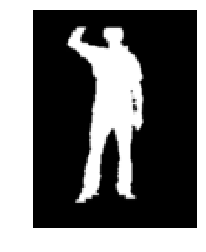

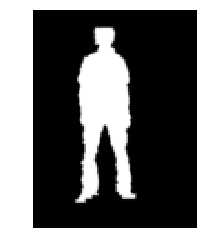

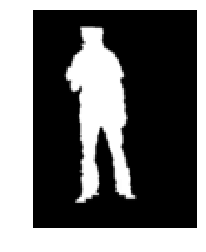

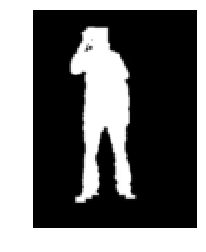

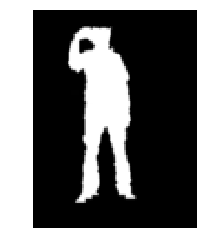

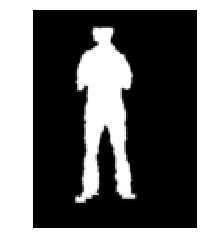

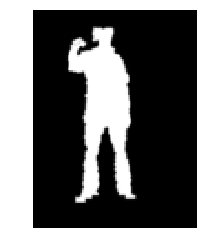

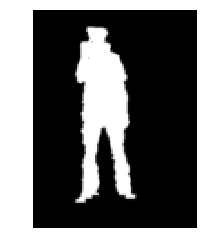

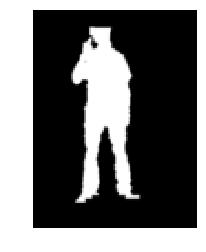

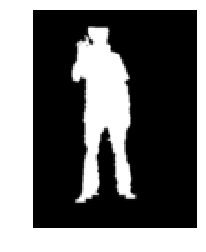

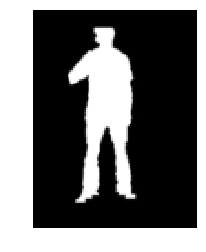

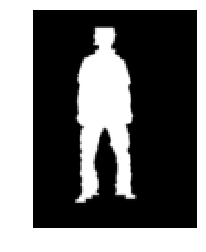

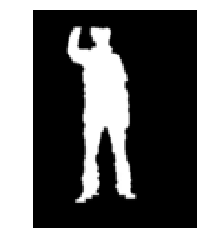

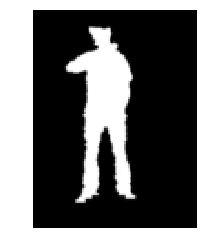

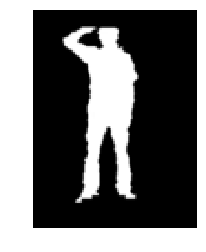

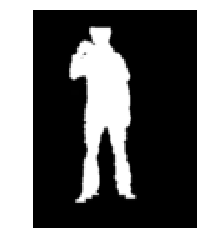

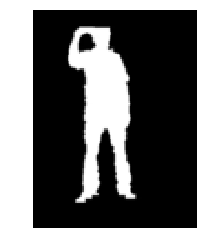

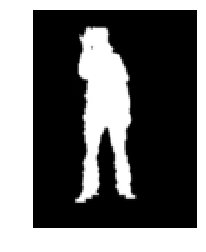

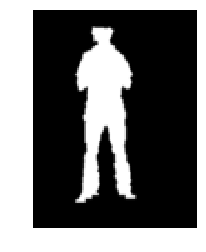

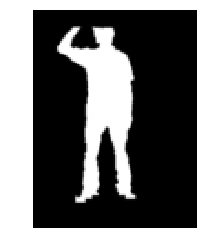

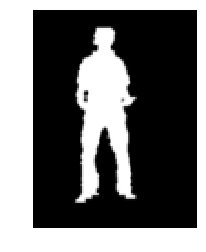

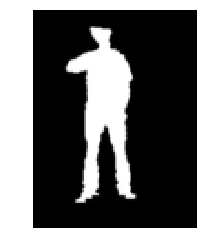

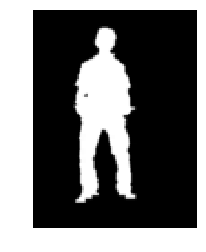

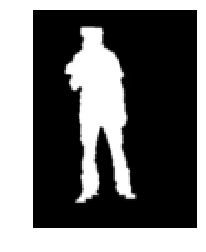

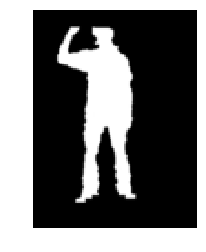

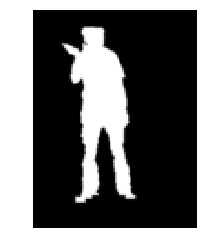

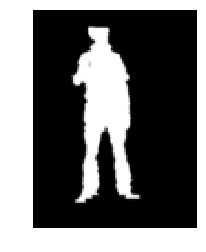

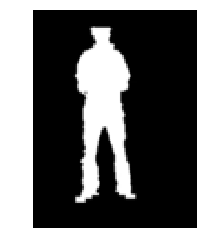

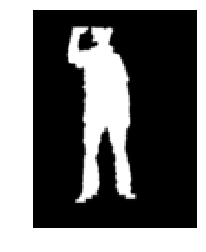

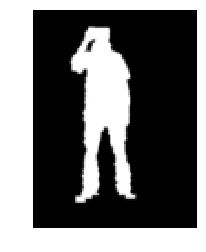

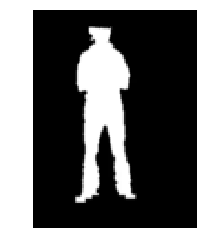

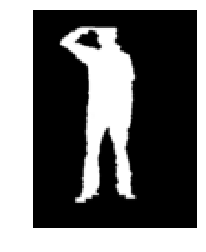

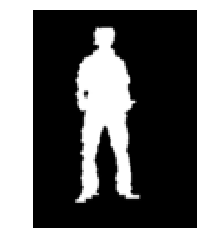

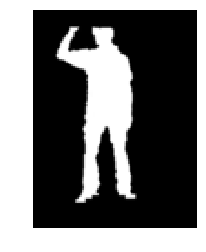

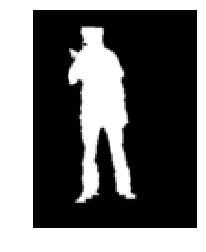

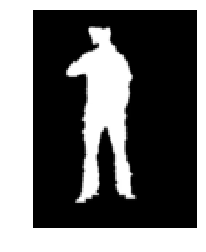

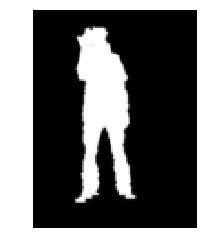

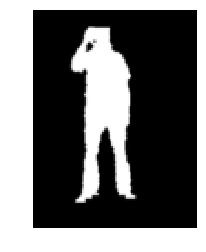

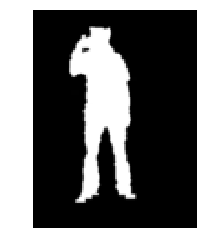

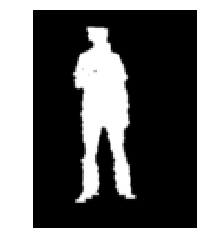

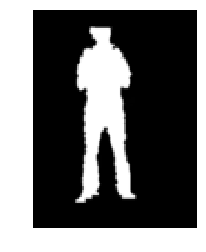

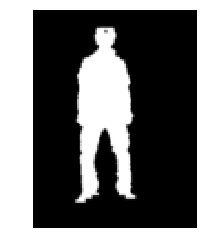

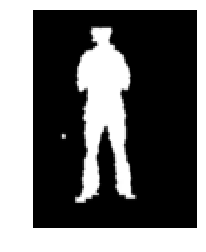

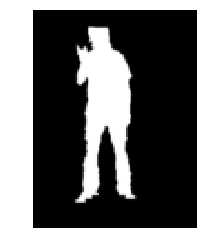

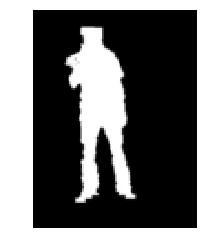

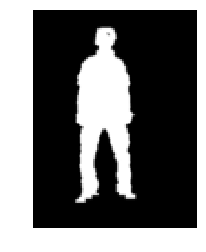

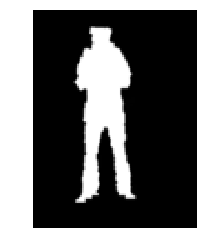

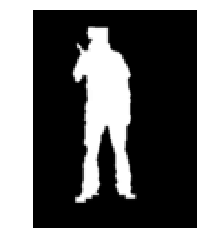

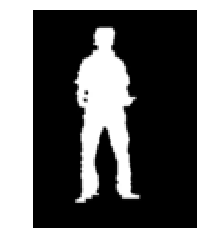

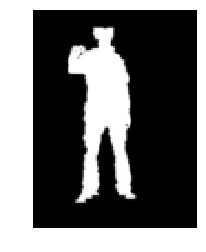

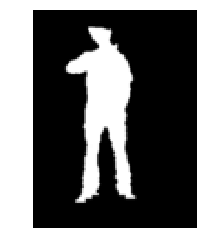

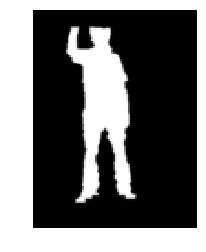

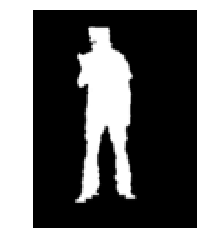

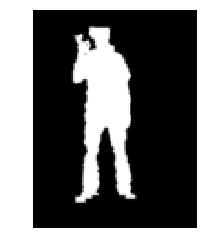

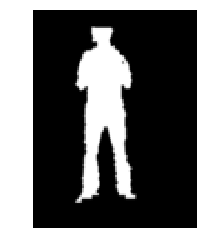

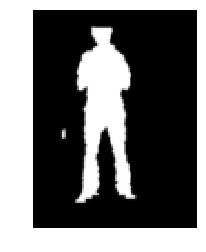

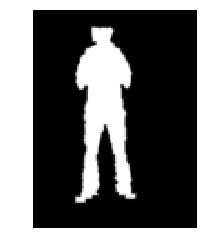

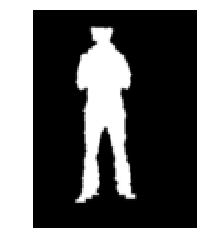

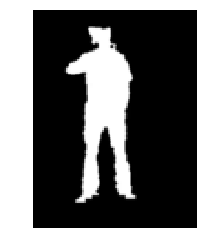

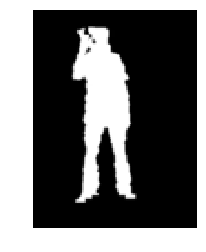

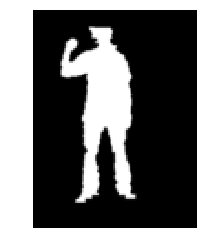

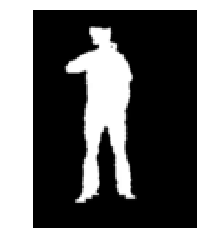

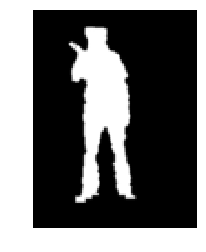

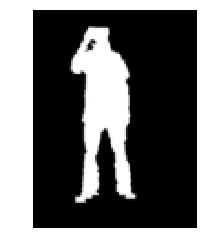

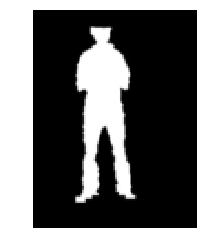

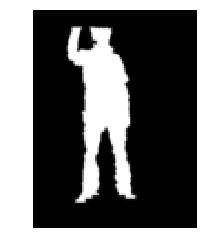

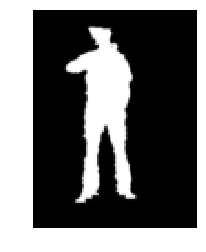

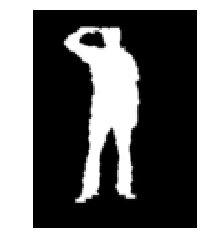

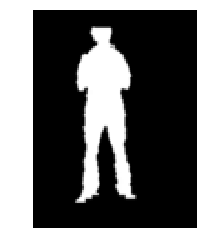

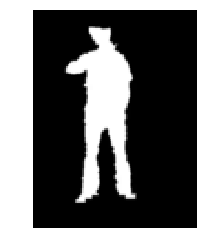

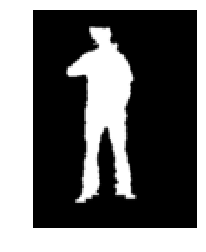

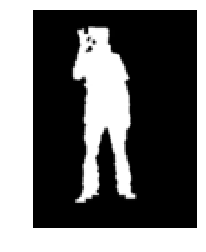

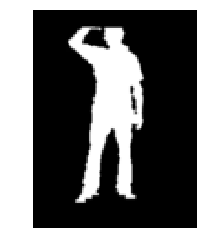

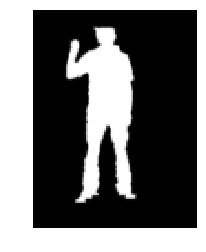

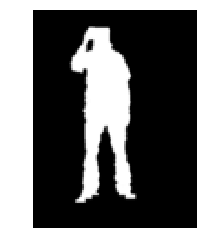

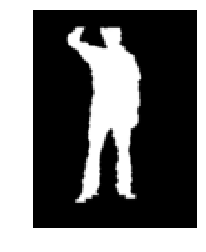

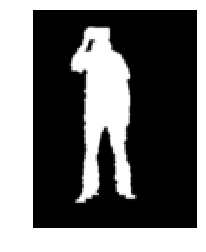

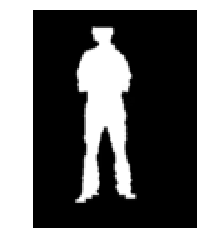

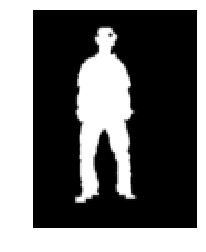

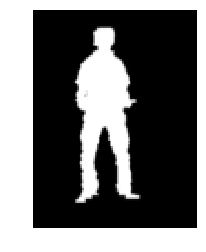

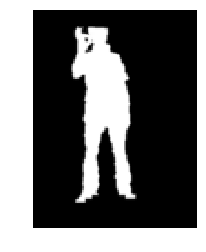

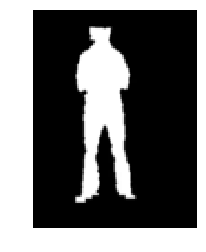

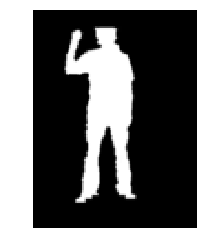

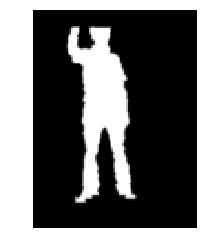

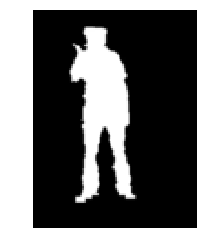

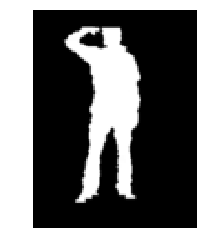

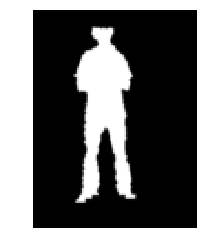

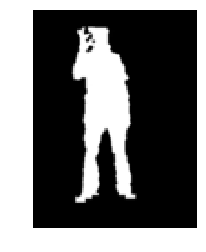

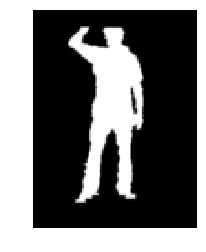

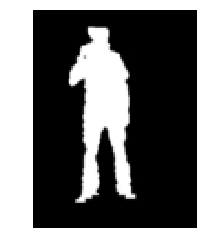

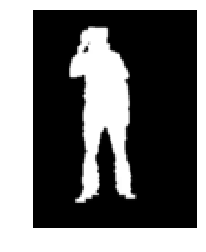

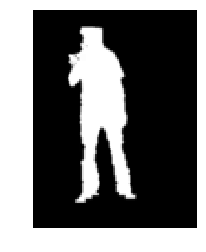

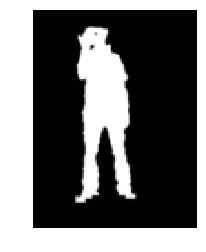

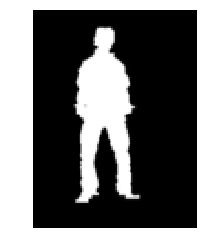

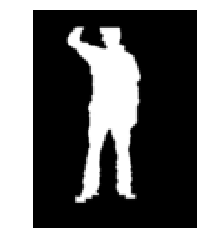

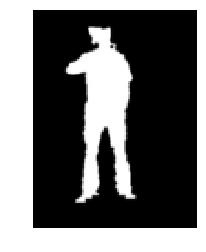

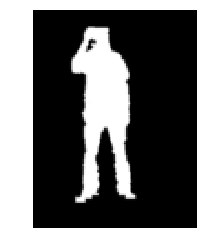

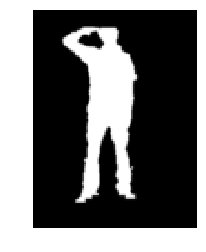

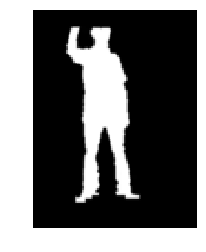

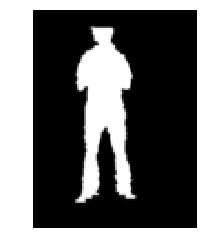

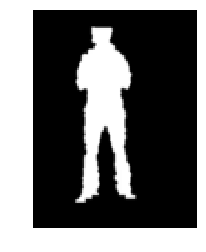

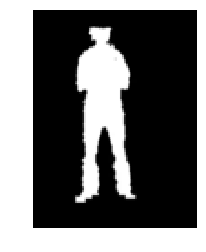

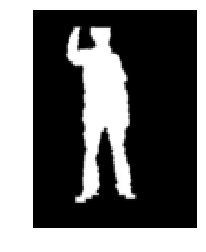

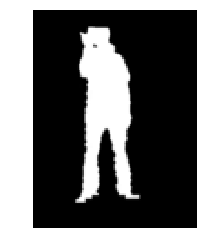

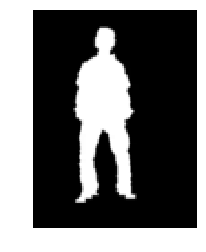

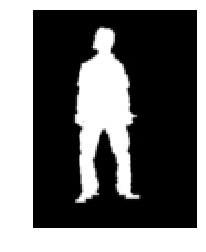

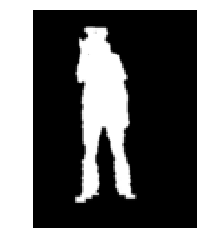

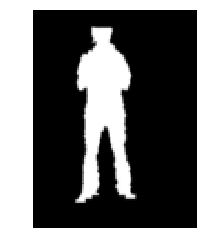

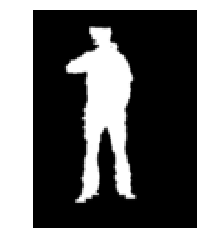

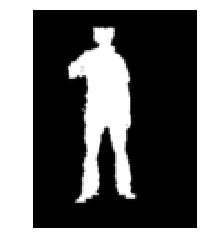

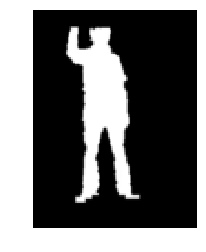

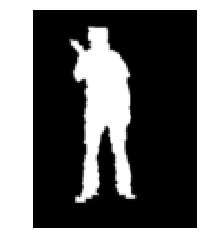

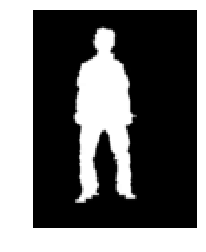

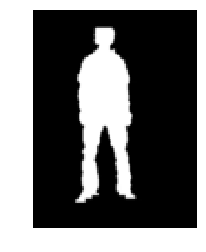

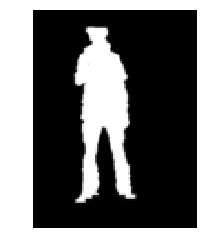

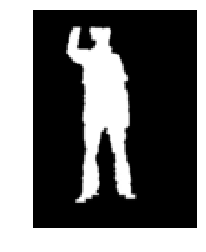

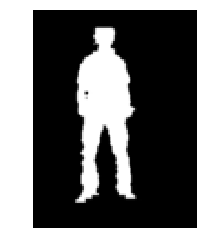

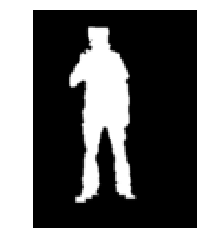

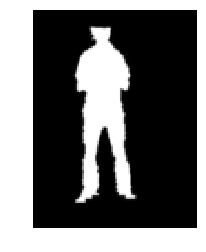

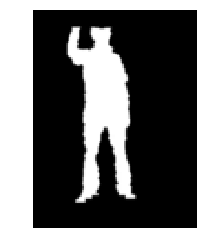

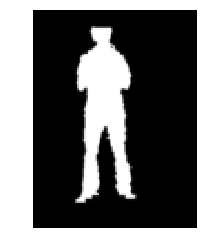

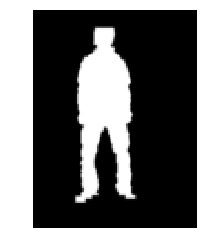

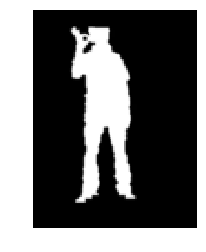

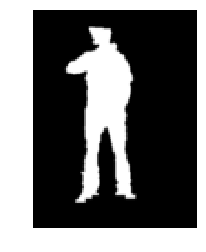

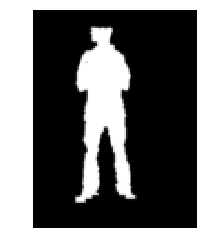

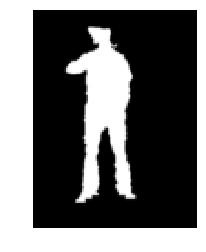

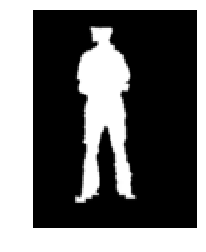

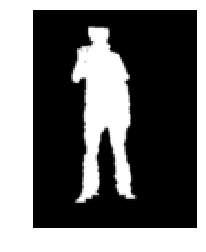

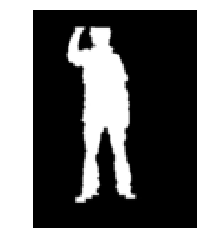

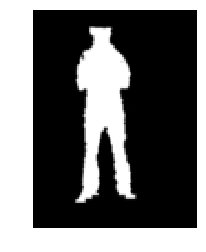

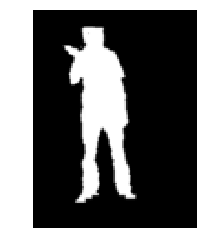

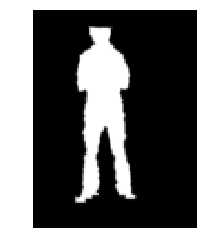

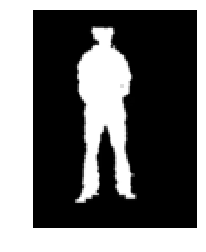

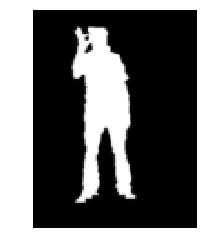

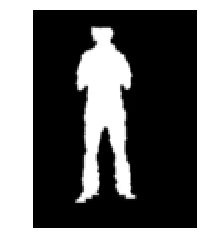

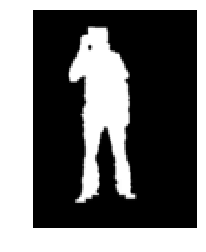

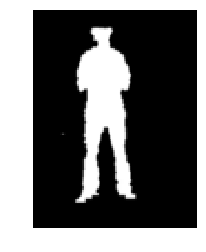

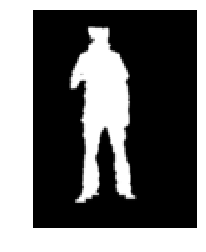

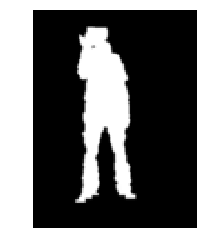

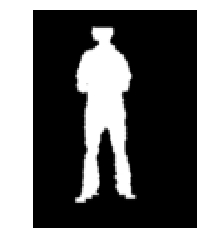

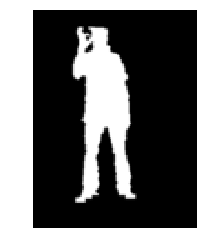

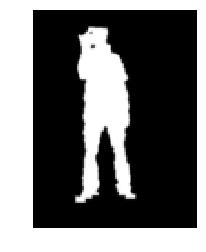

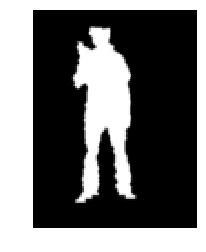

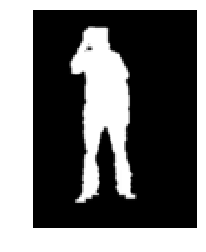

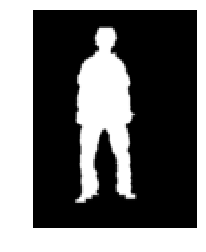

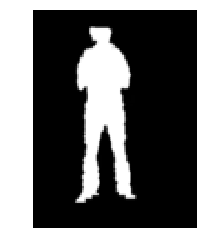

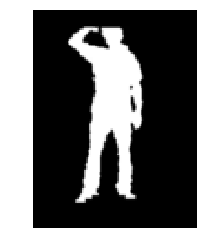

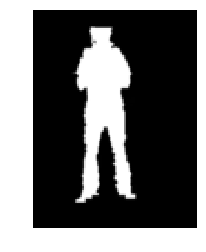

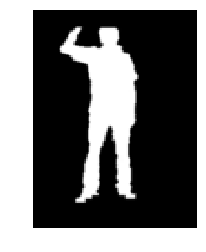

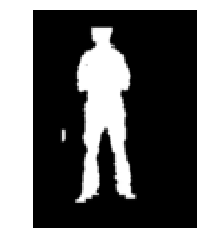

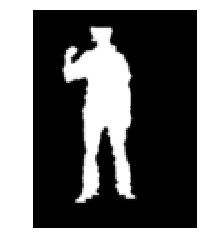

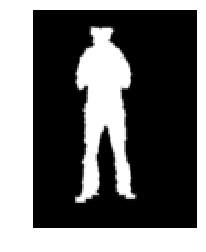

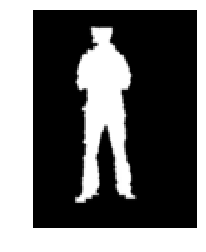

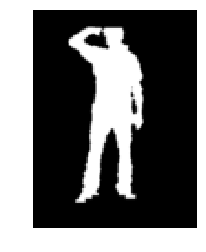

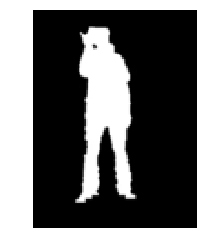

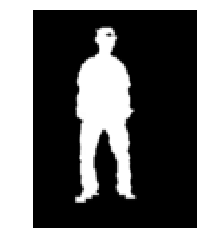

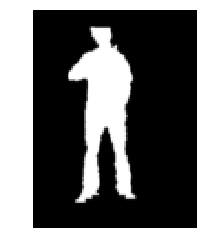

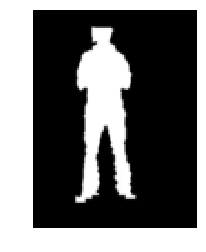

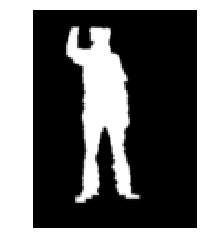

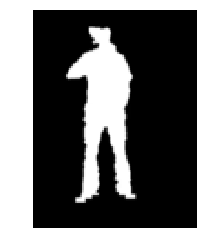

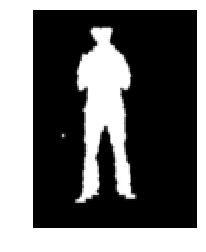

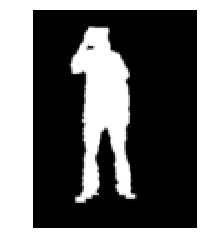

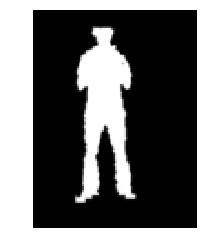

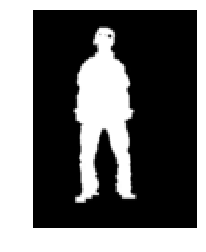

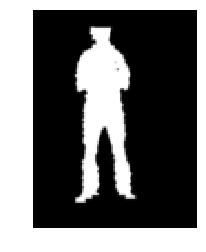

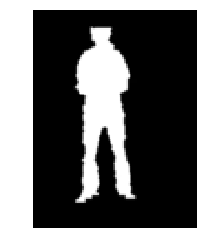

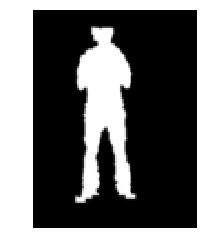

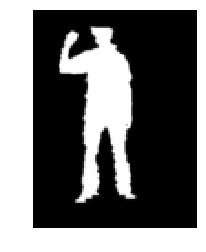

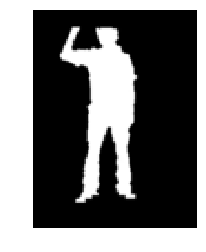

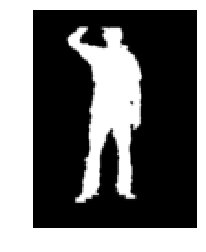

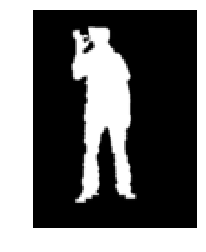

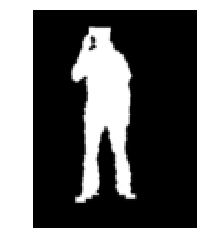

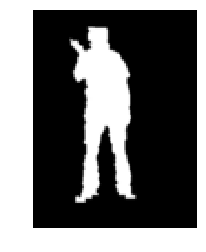

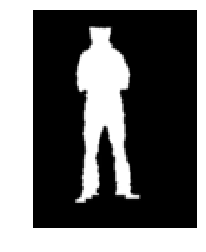

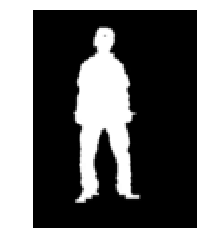

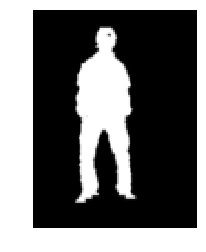

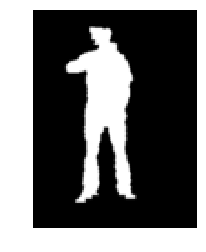

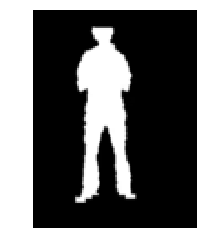

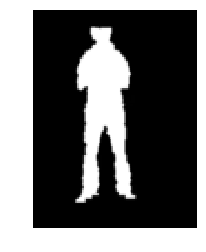

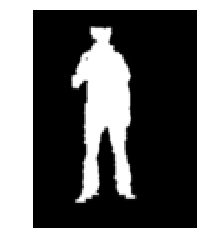

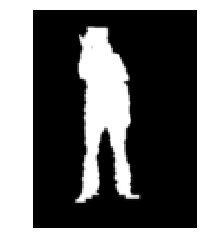

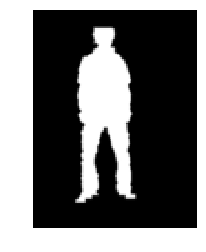

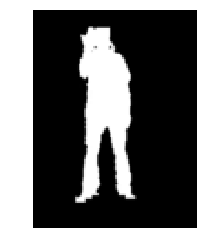

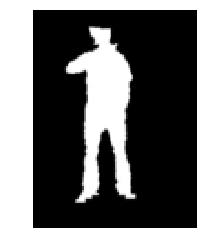

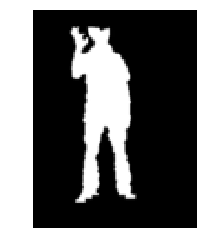

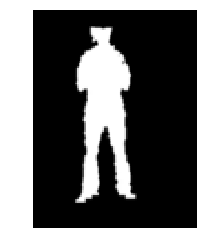

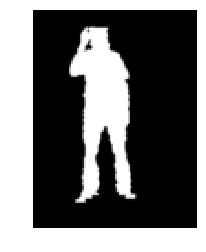

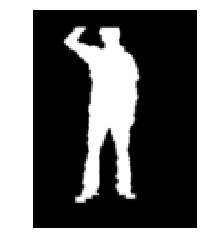

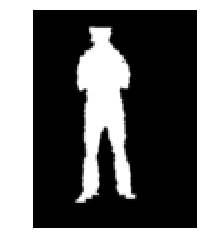

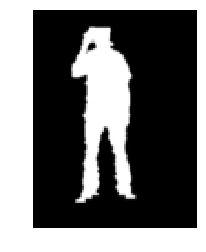

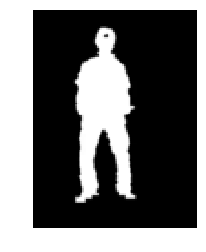

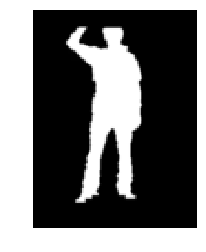

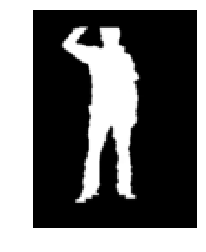

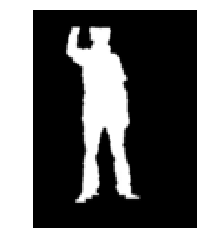

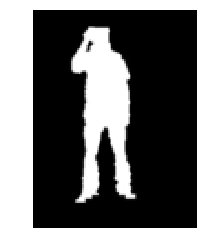

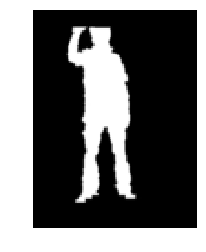

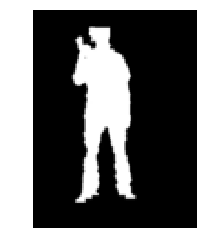

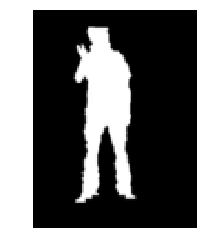

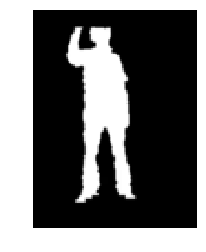

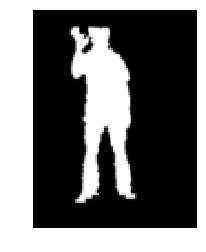

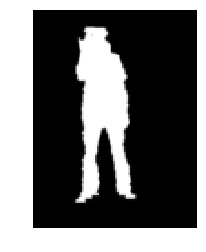

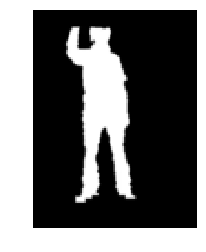

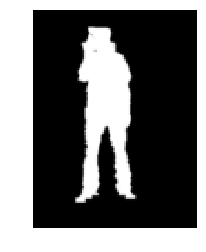

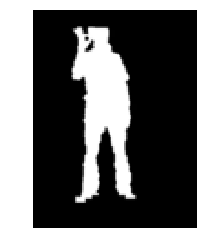

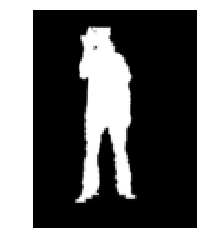

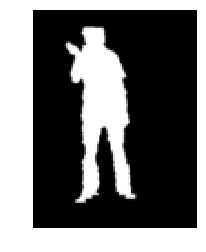

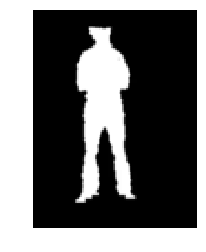

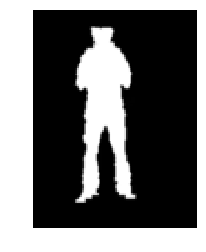

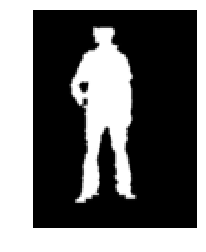

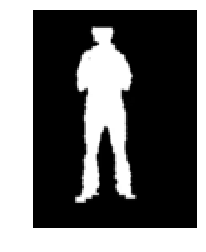

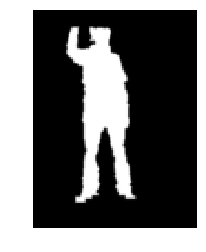

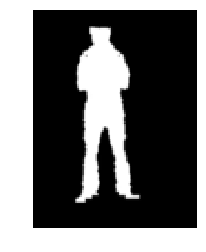

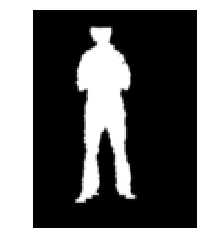

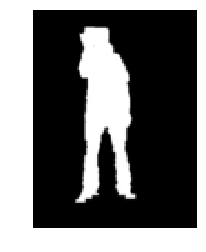

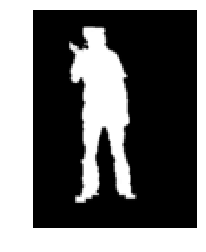

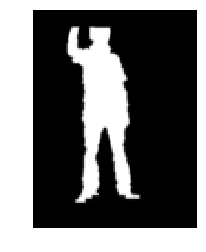

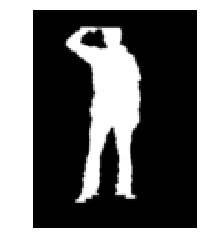

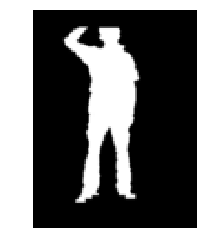

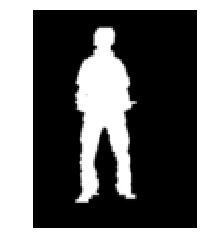

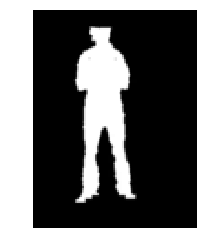

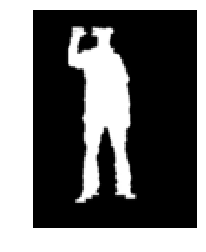

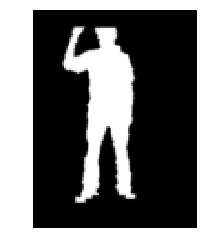

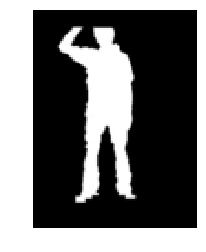

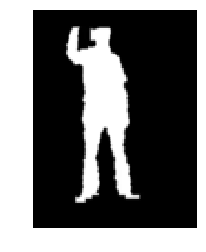

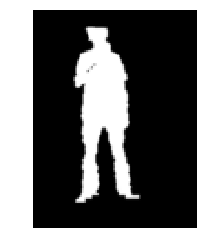

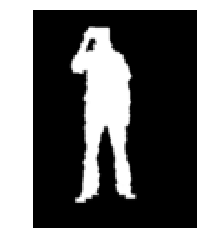

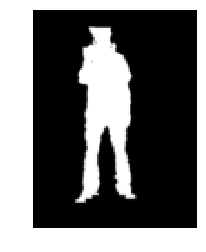

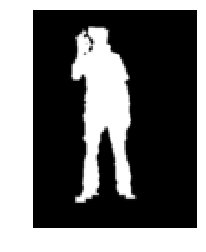

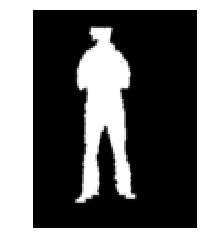

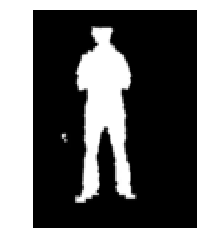

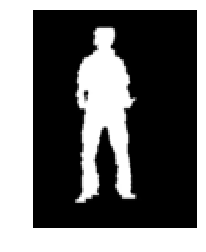

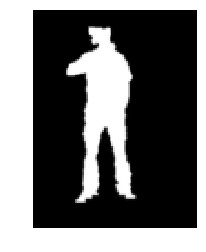

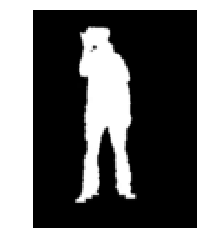

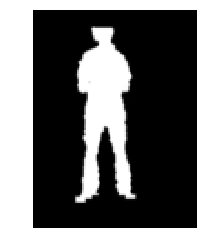

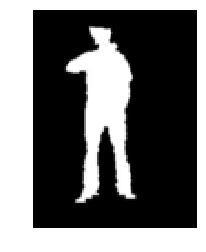

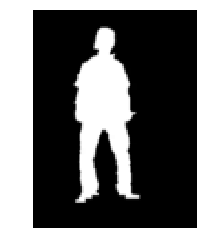

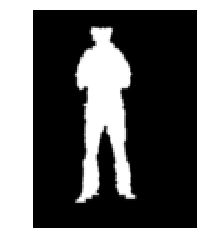

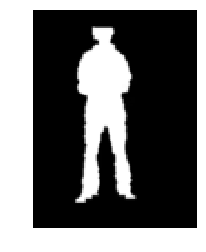

In [113]:
for i in range(n_samples):
    if data['subjectLabels'][i] == 1:
        plot(data['segmentation'][i])

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


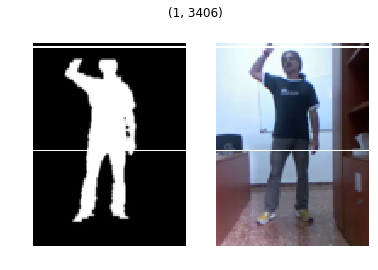

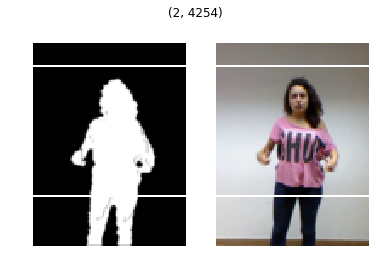

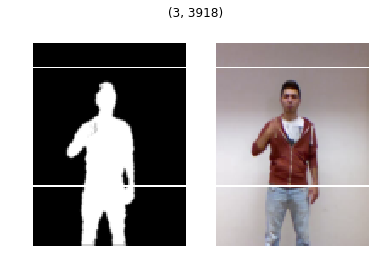

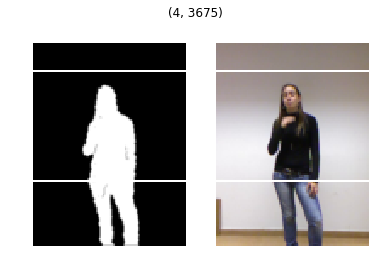

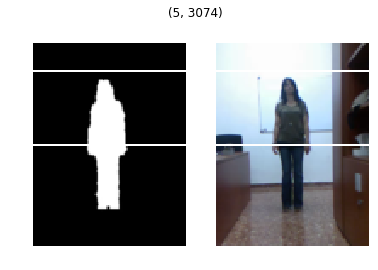

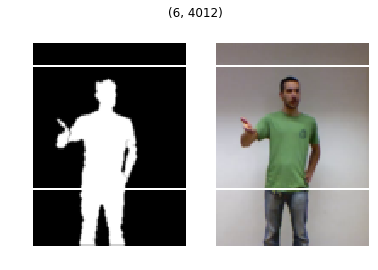

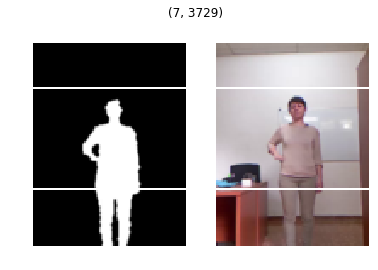

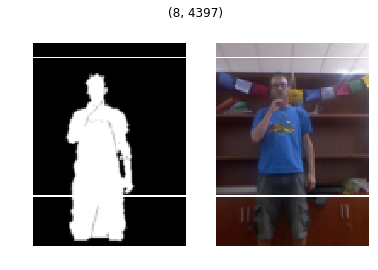

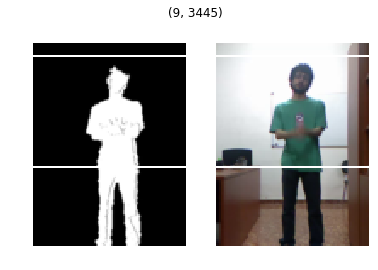

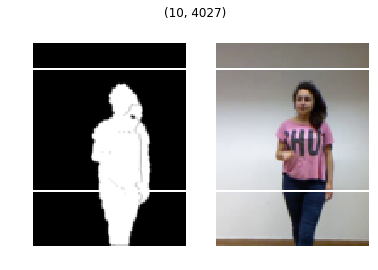

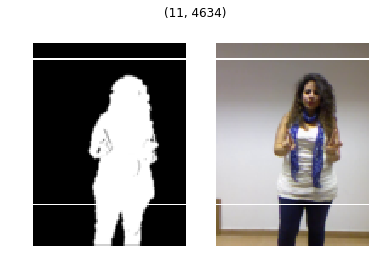

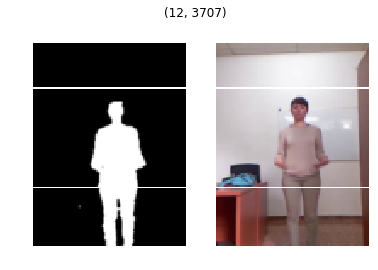

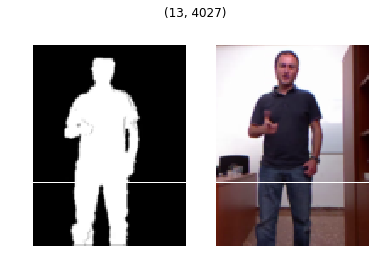

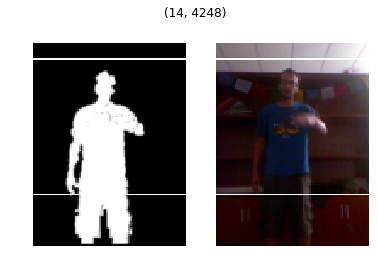

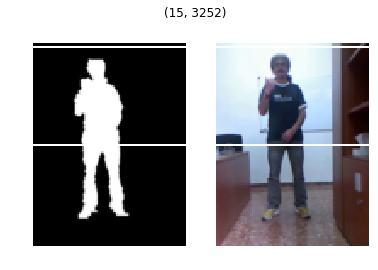

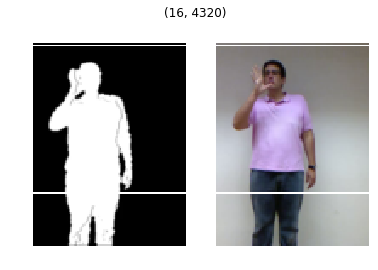

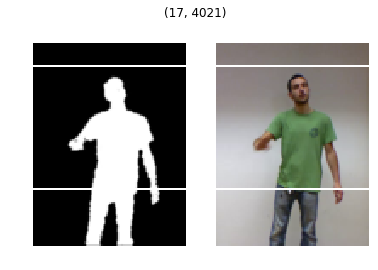

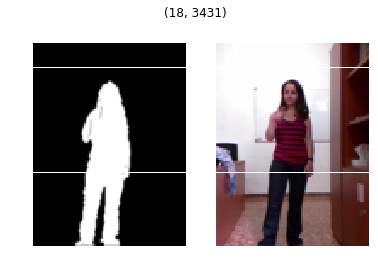

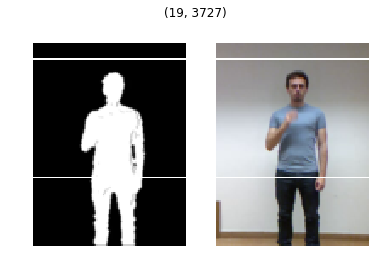

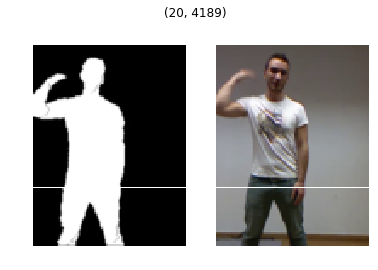

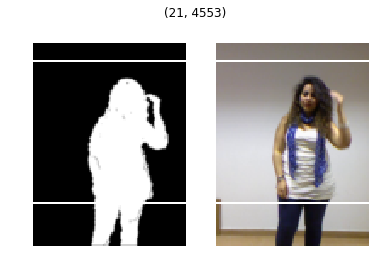

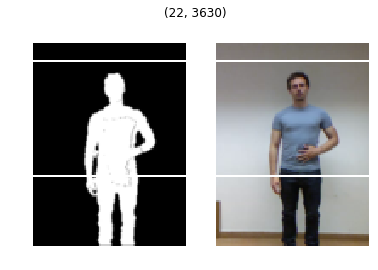

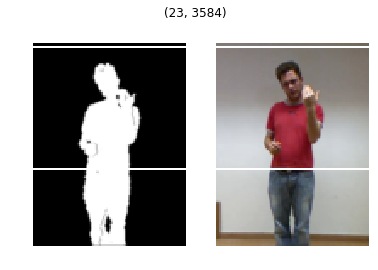

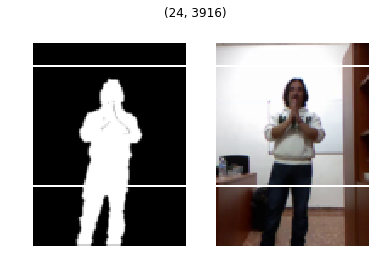

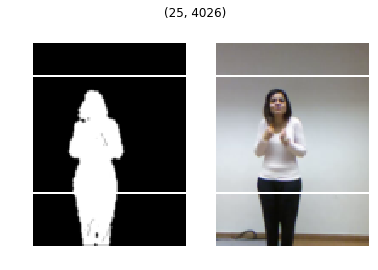

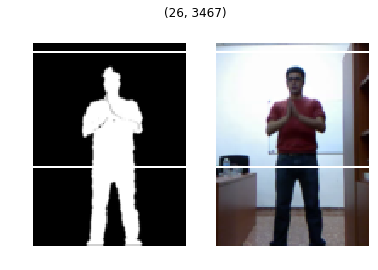

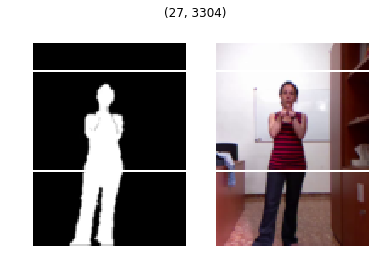

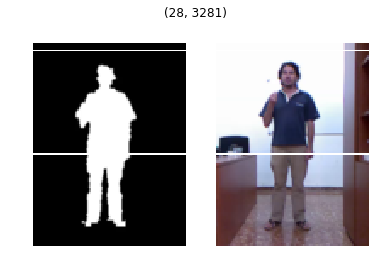

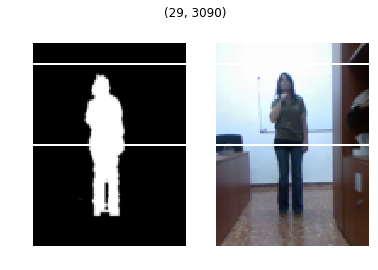

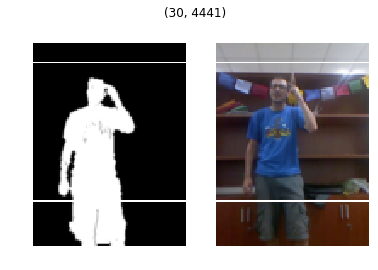

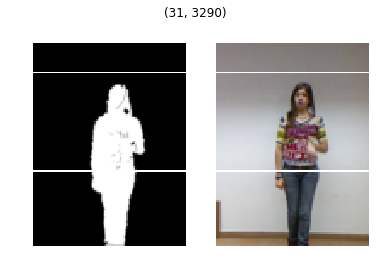

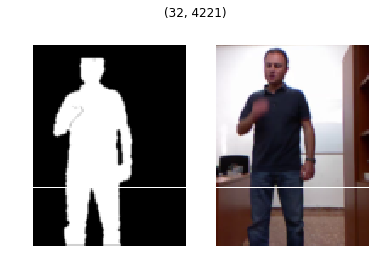

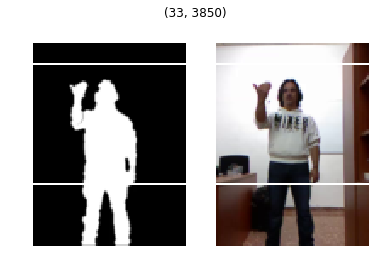

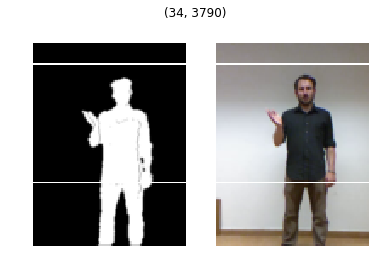

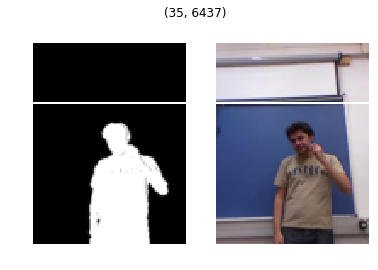

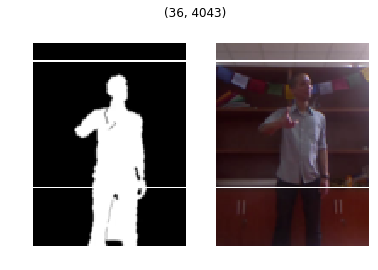

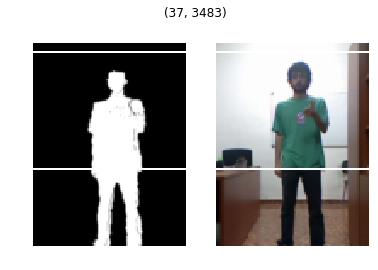

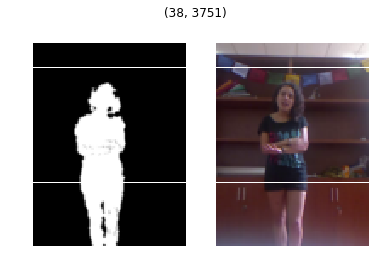

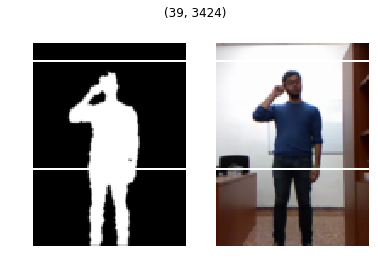

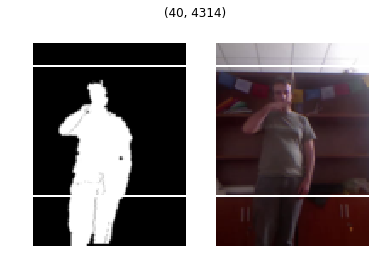

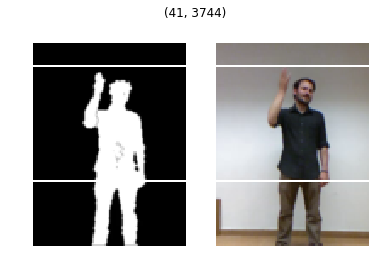

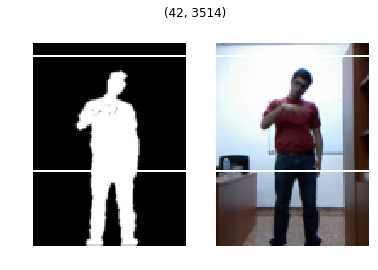

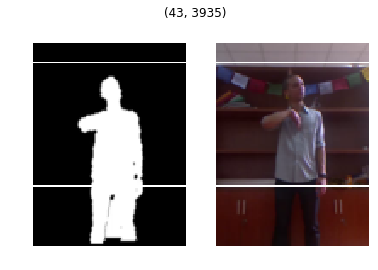

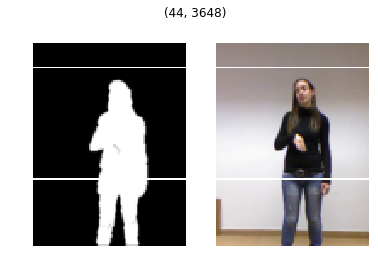

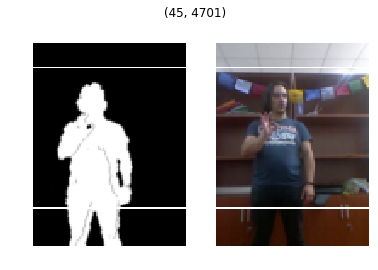

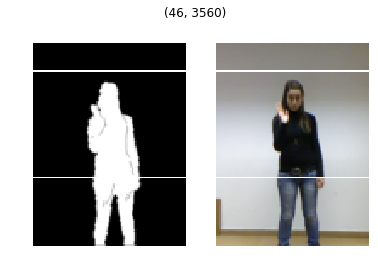

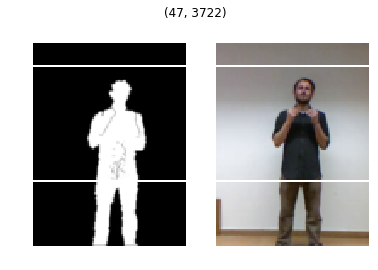

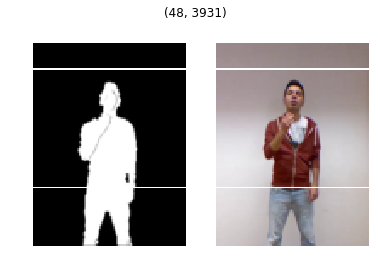

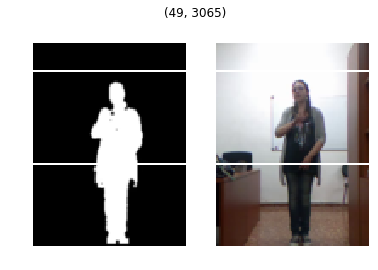

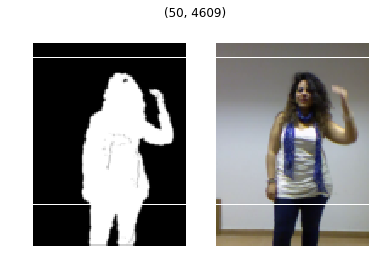

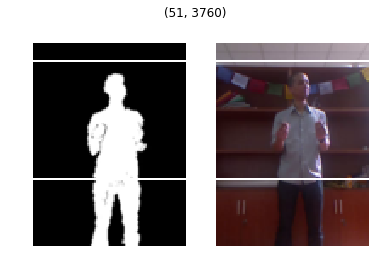

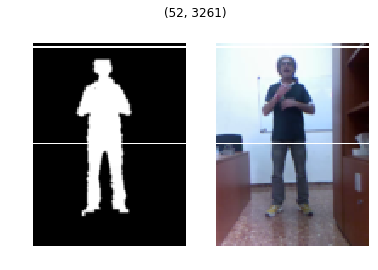

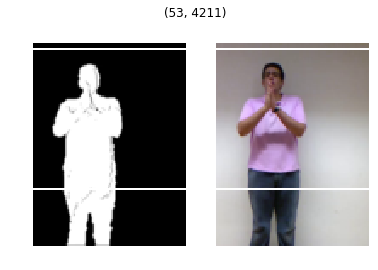

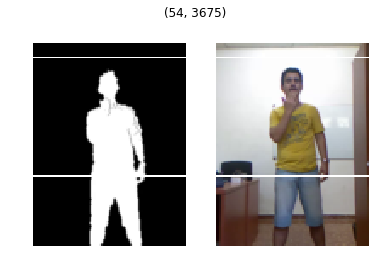

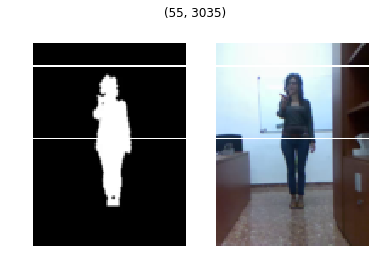

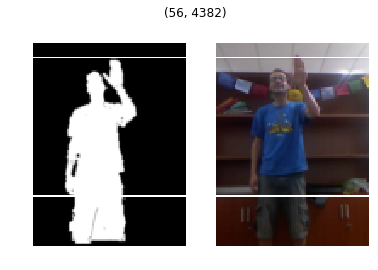

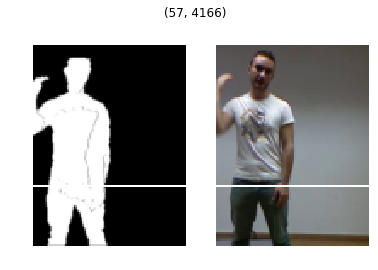

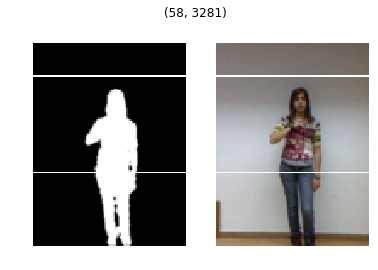

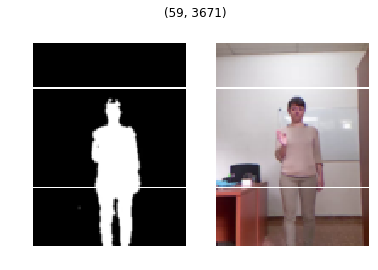

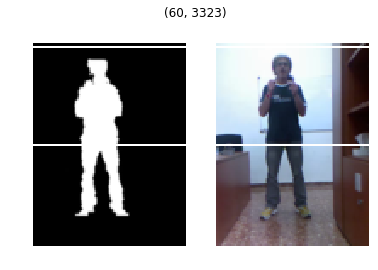

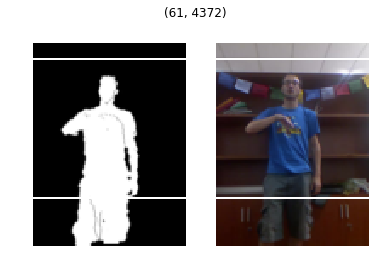

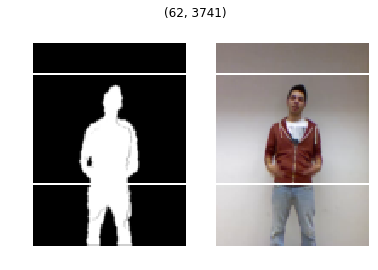

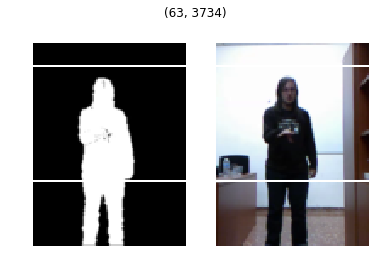

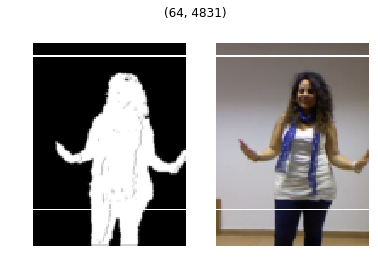

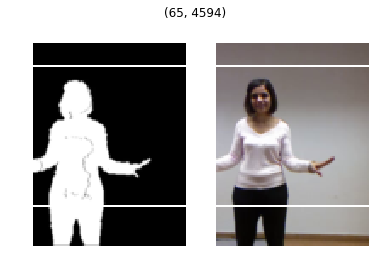

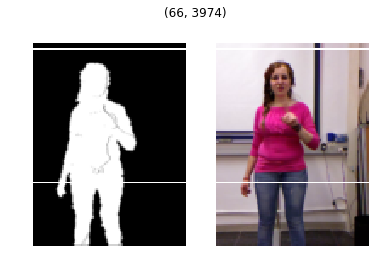

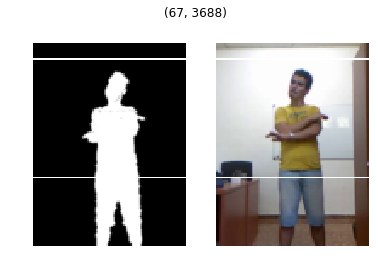

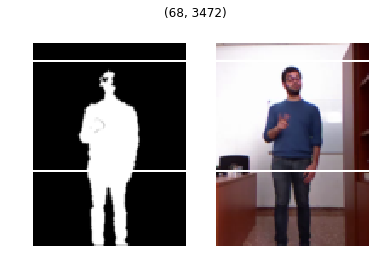

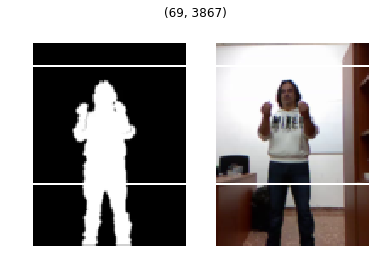

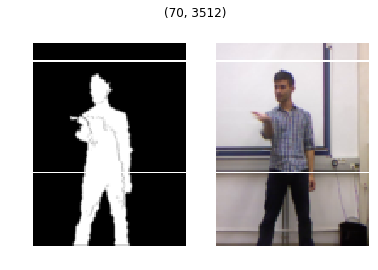

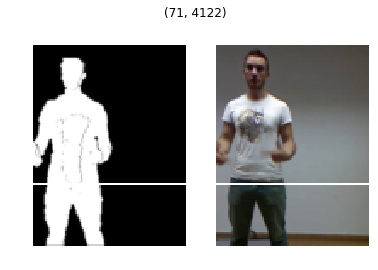

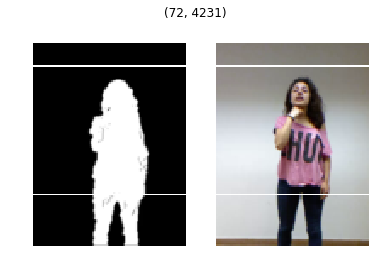

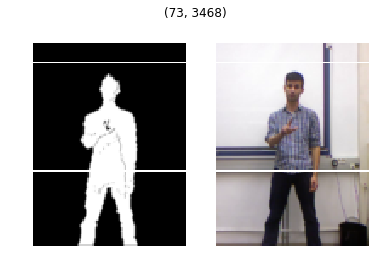

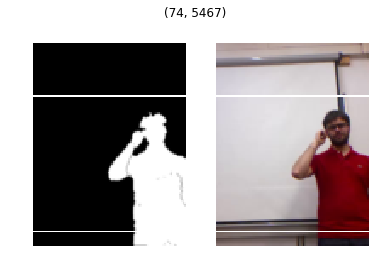

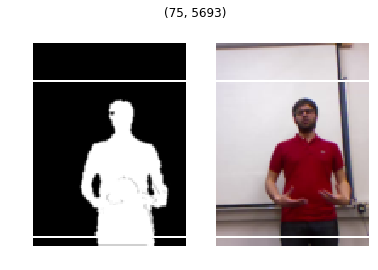

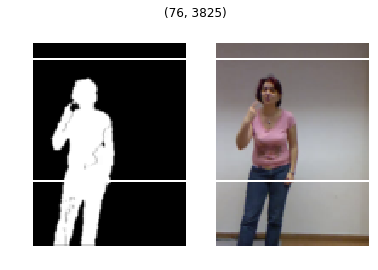

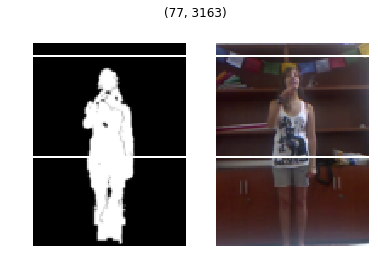

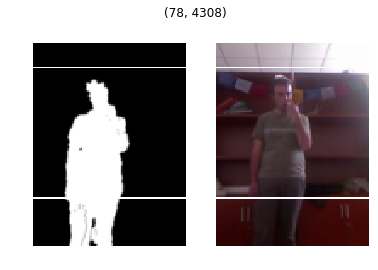

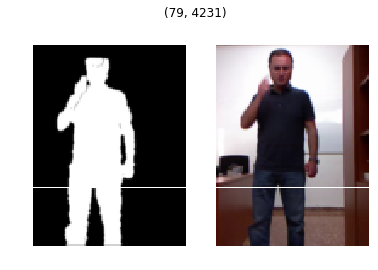

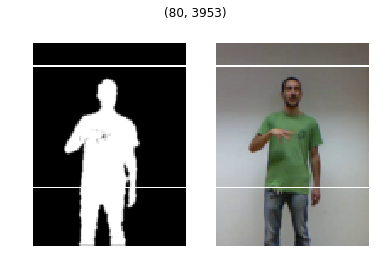

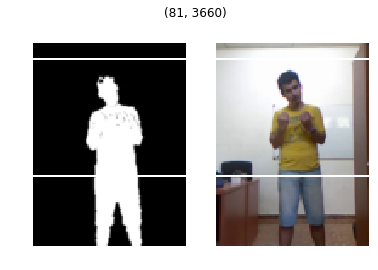

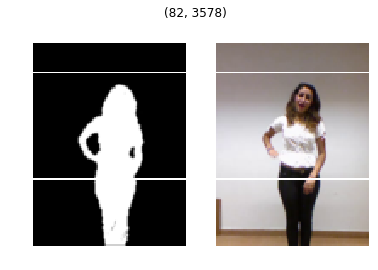

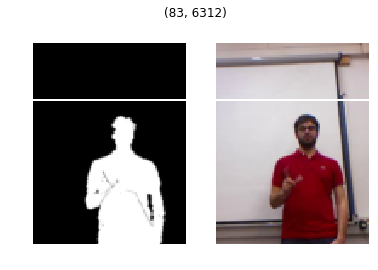

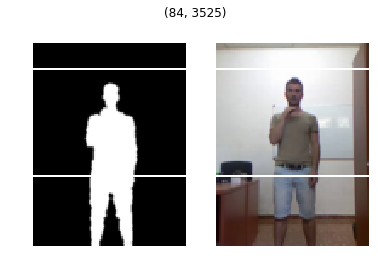

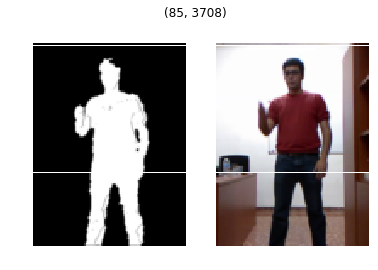

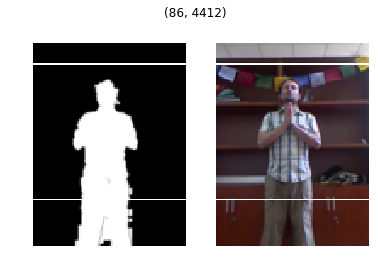

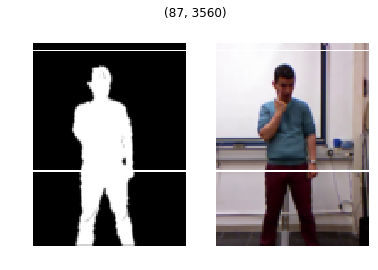

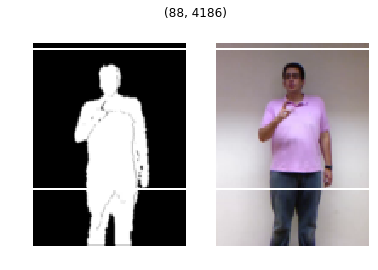

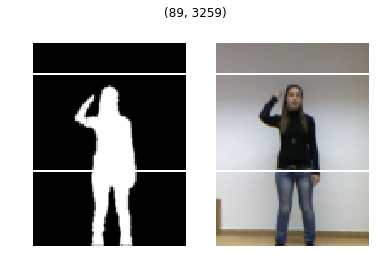

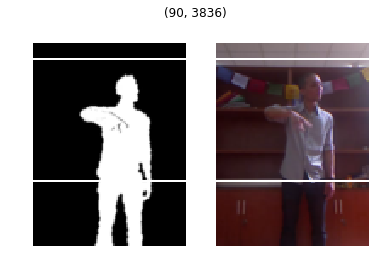

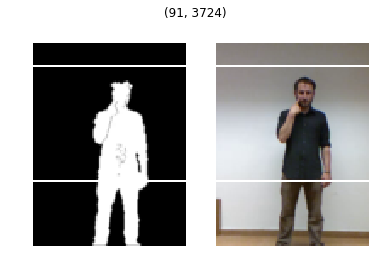

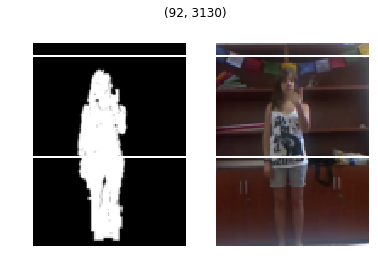

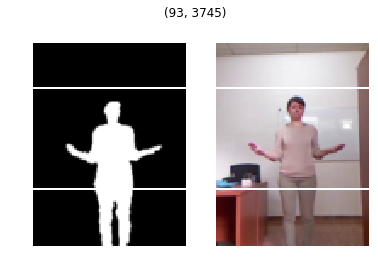

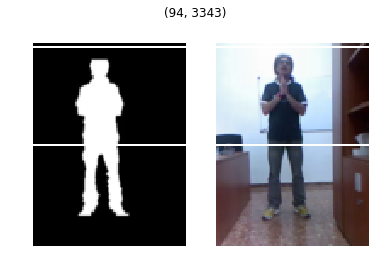

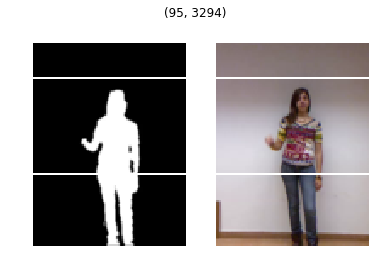

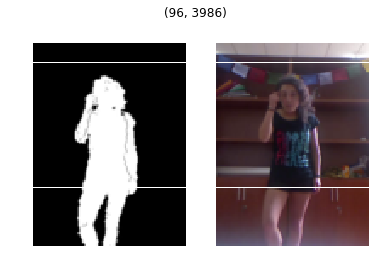

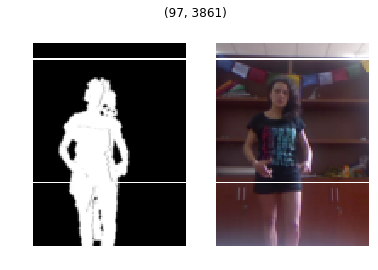

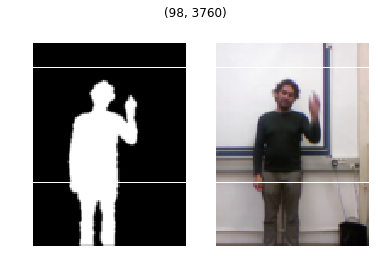

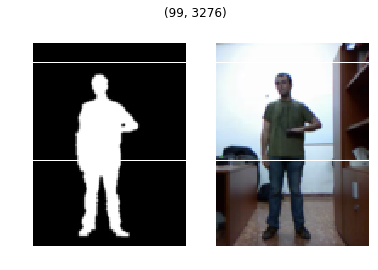

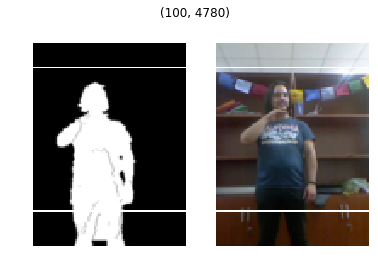

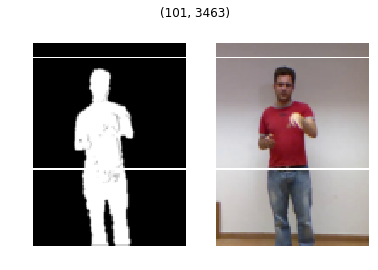

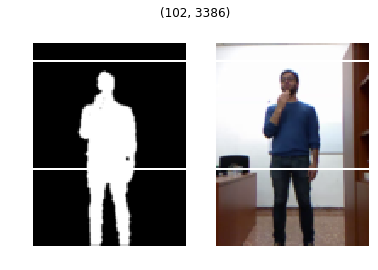

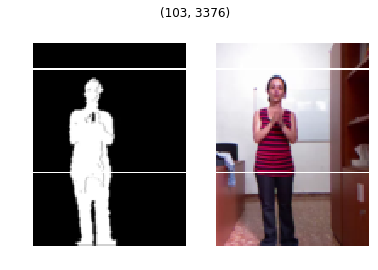

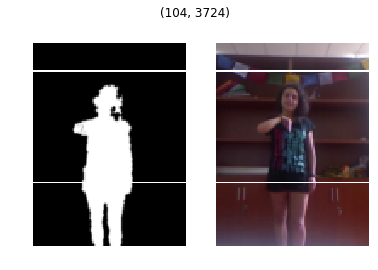

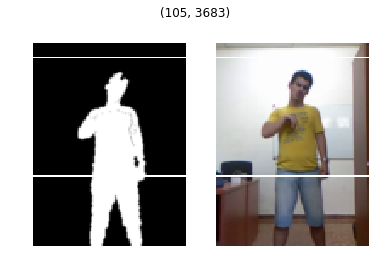

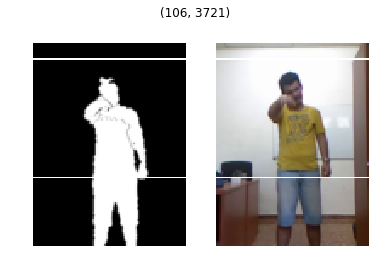

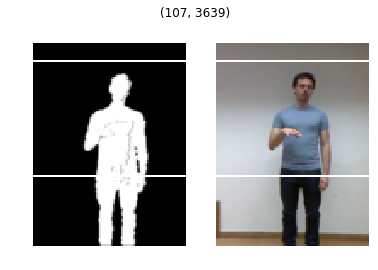

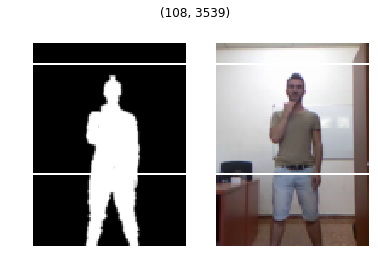

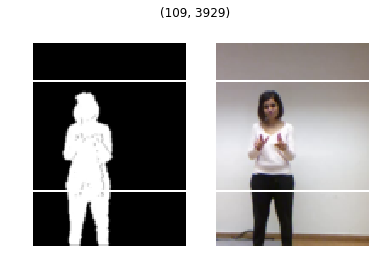

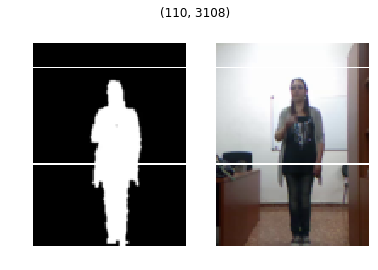

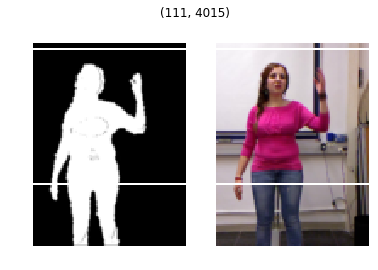

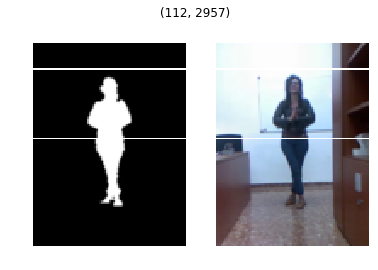

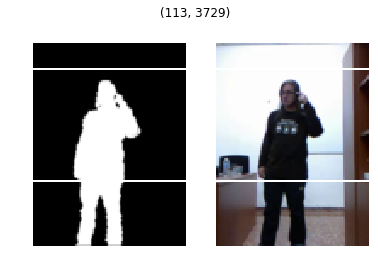

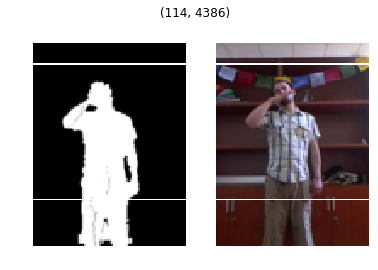

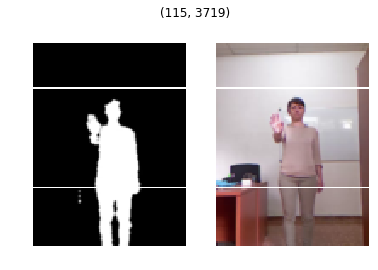

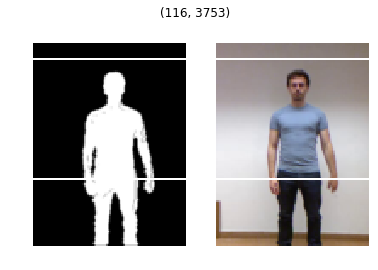

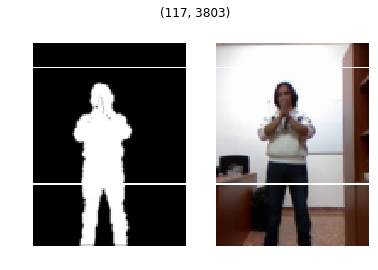

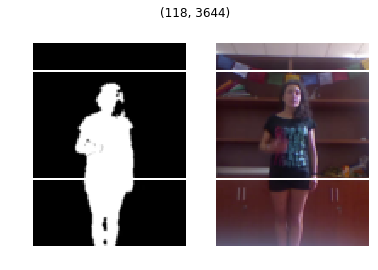

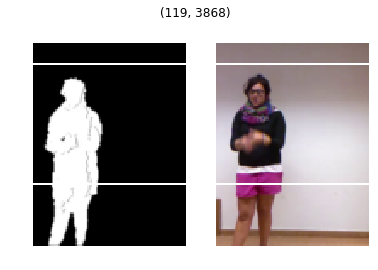

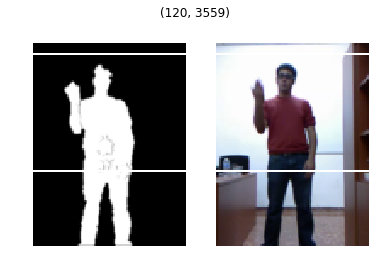

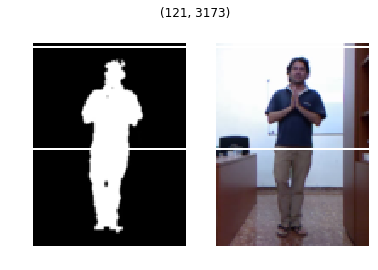

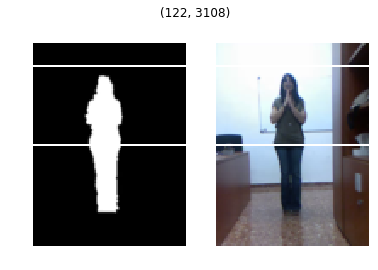

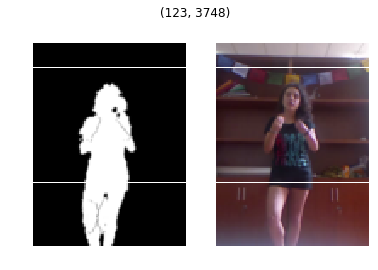

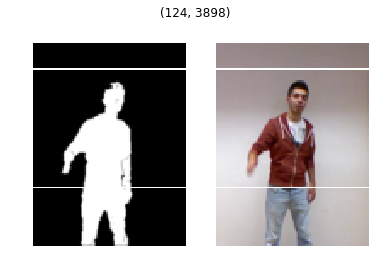

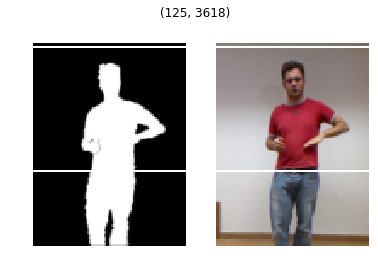

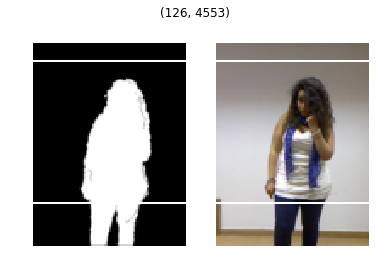

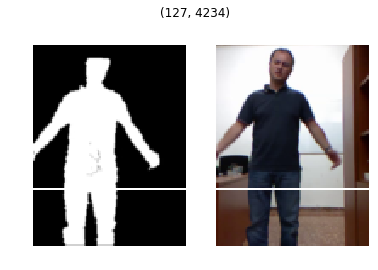

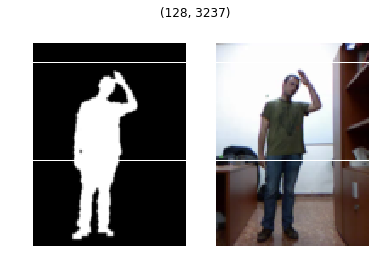

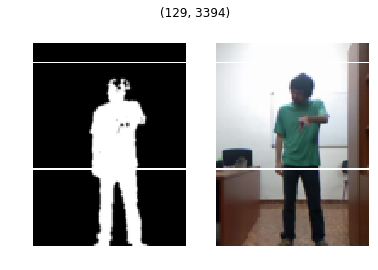

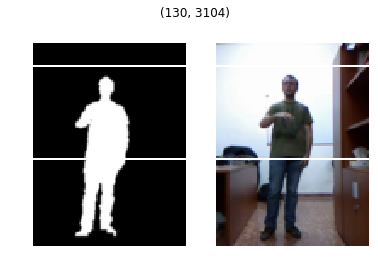

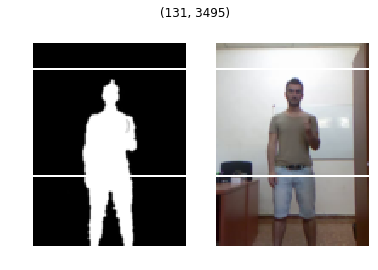

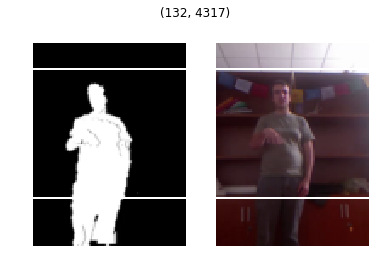

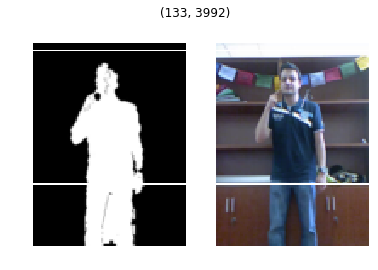

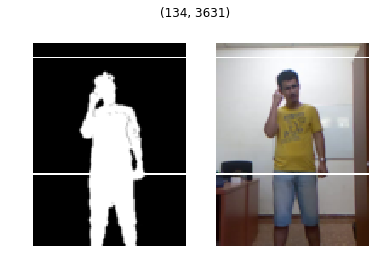

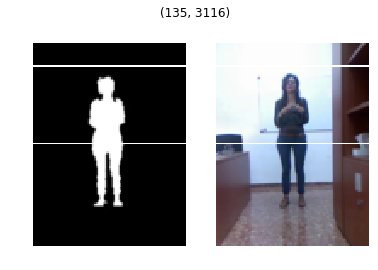

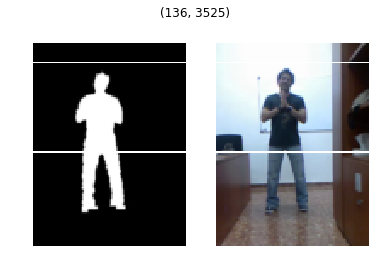

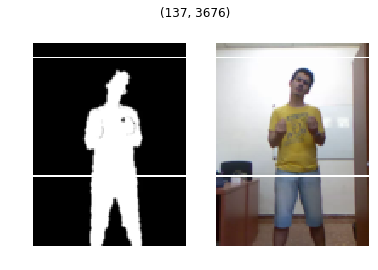

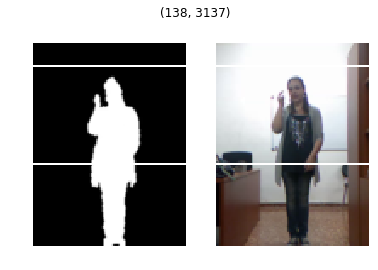

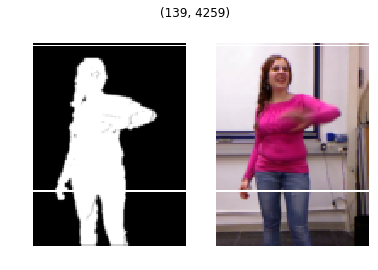

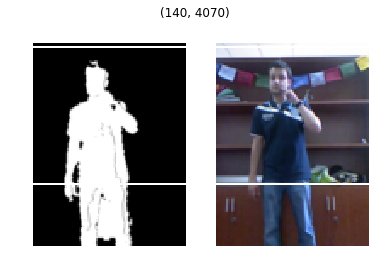

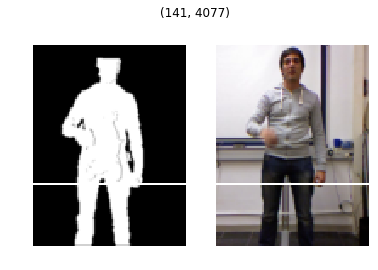

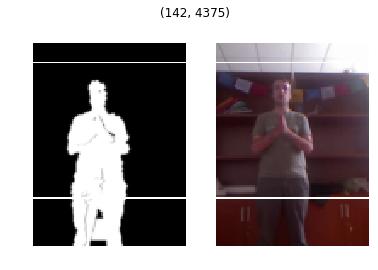

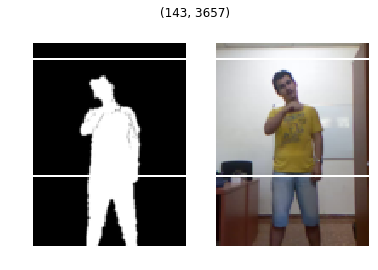

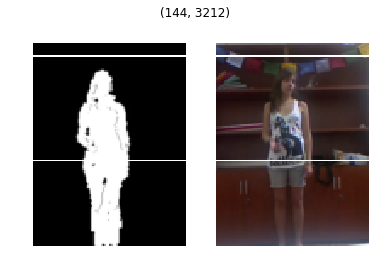

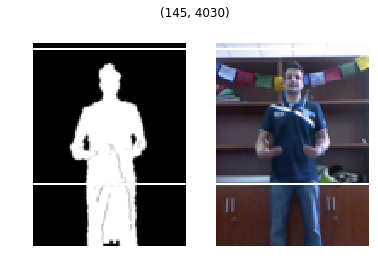

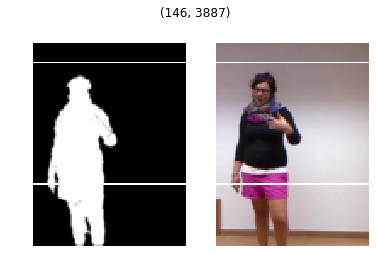

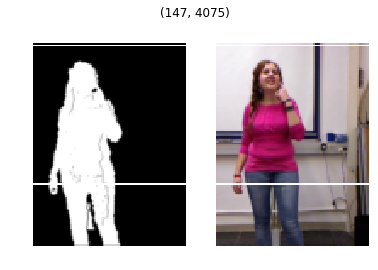

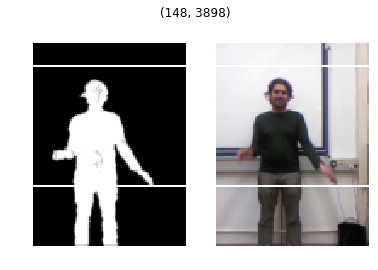

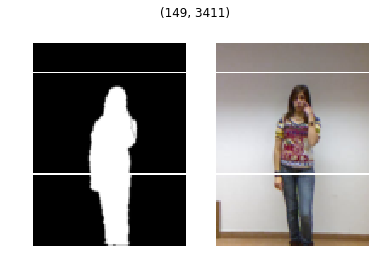

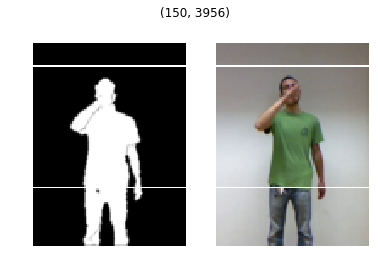

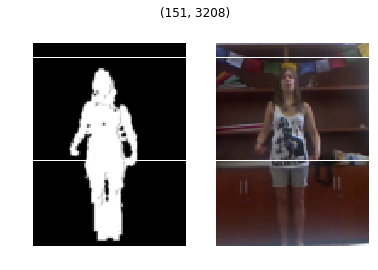

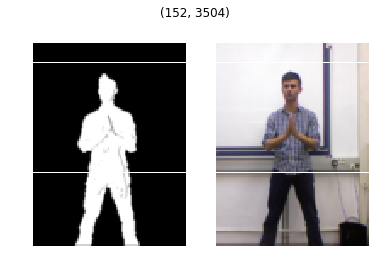

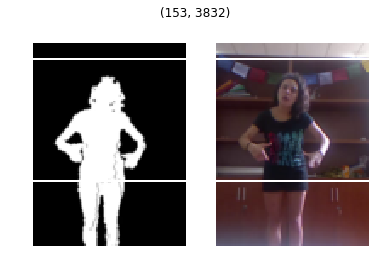

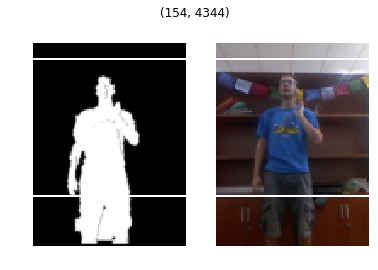

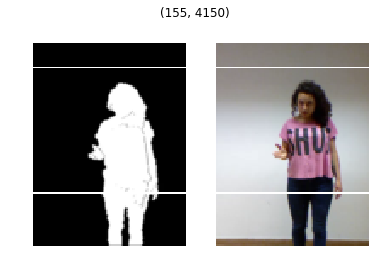

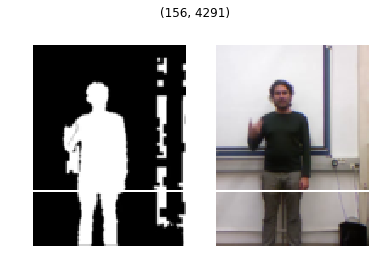

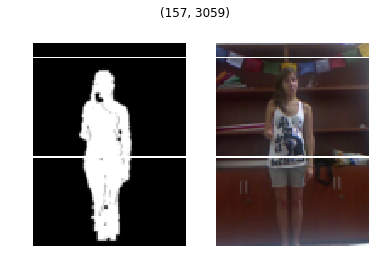

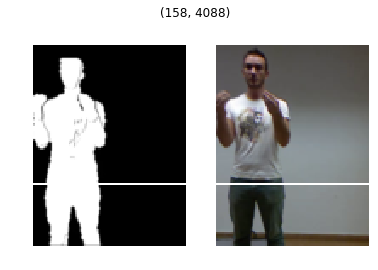

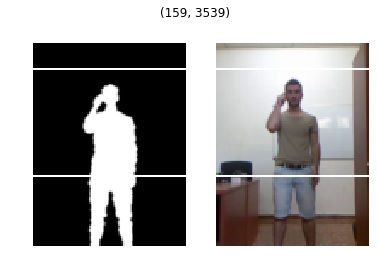

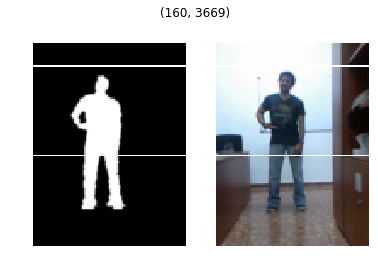

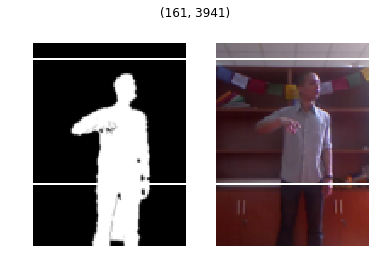

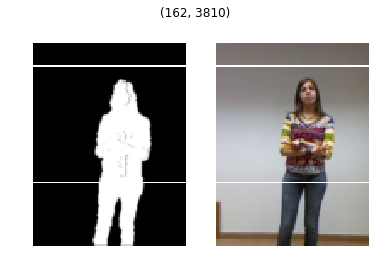

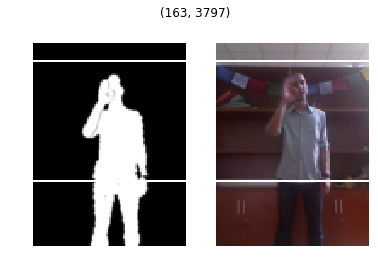

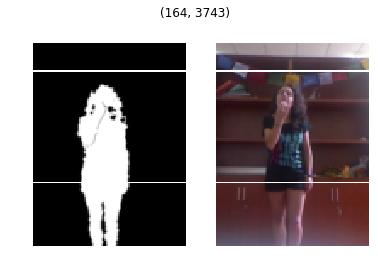

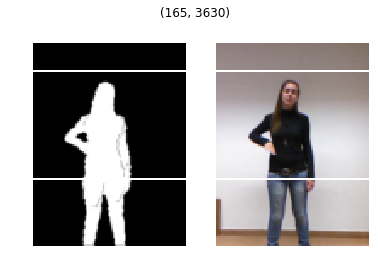

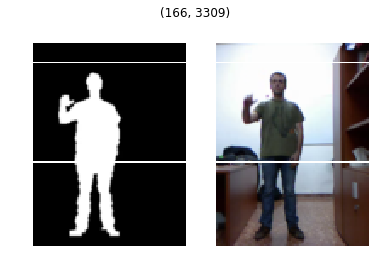

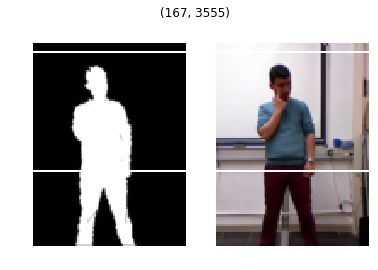

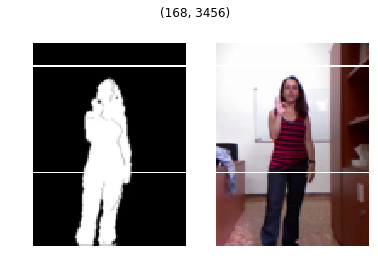

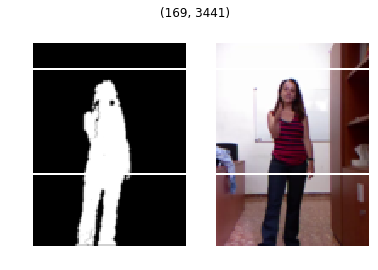

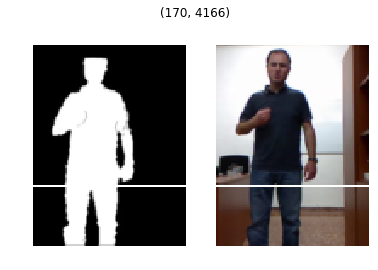

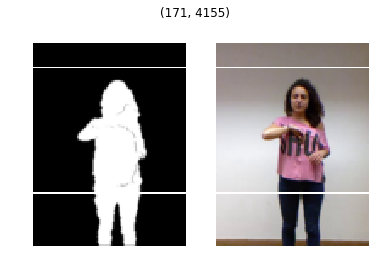

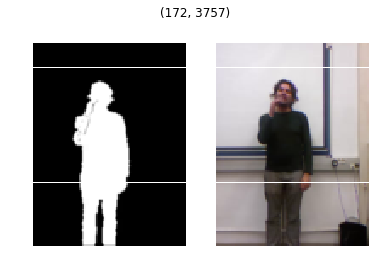

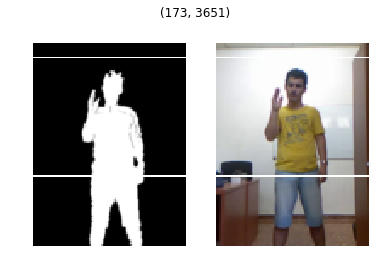

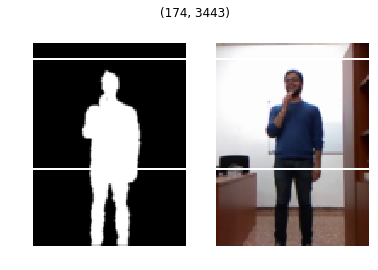

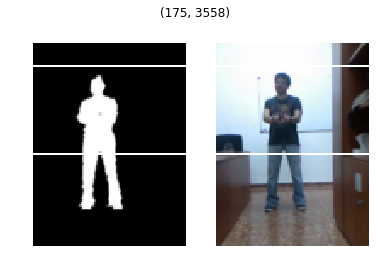

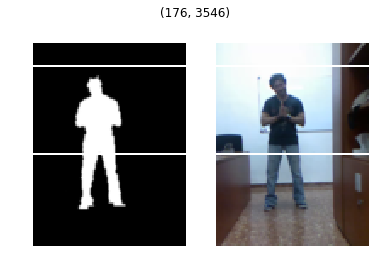

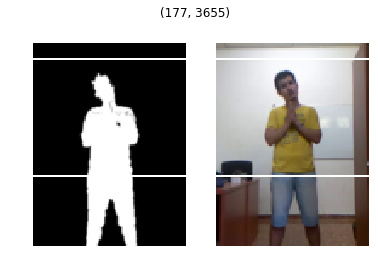

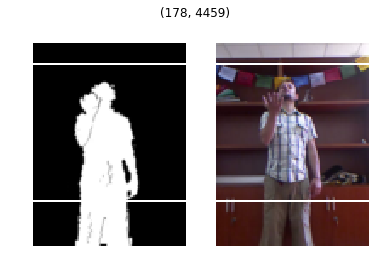

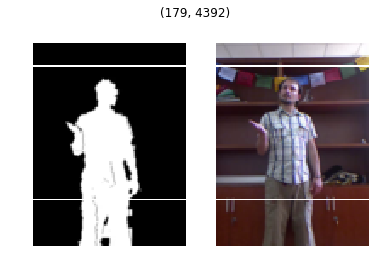

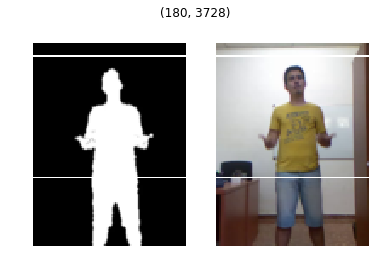

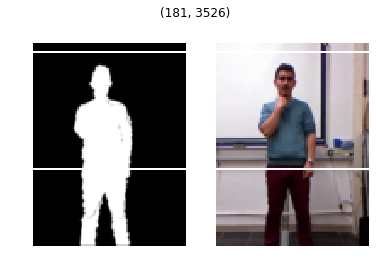

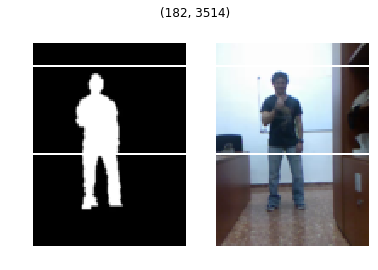

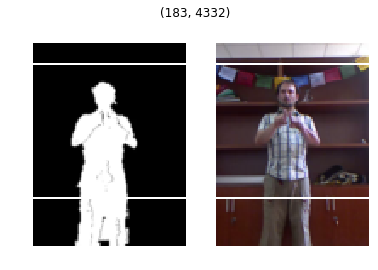

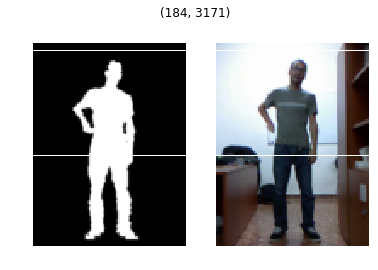

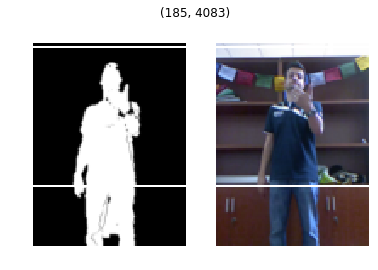

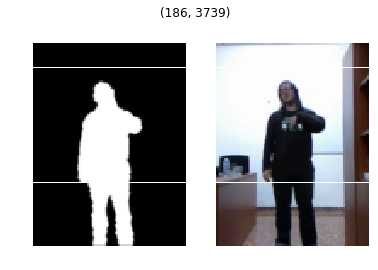

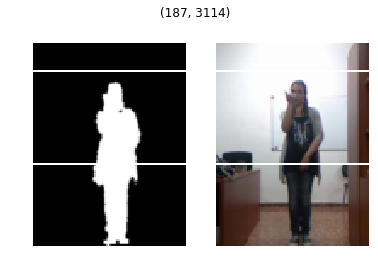

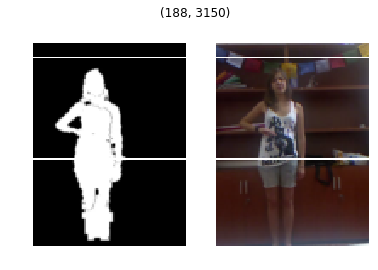

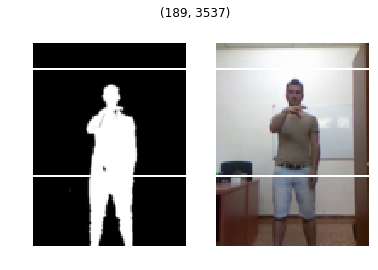

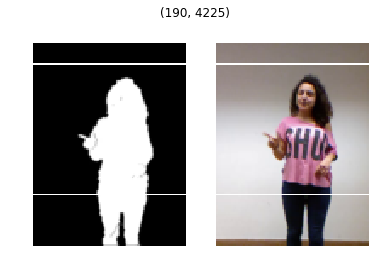

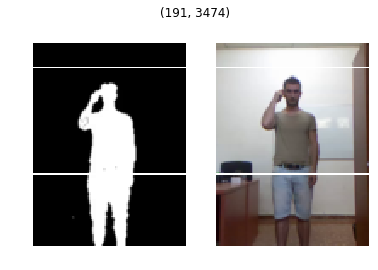

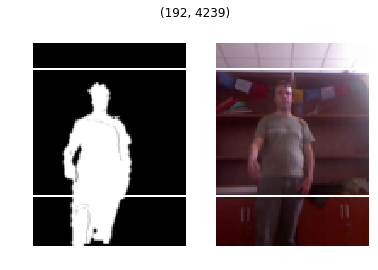

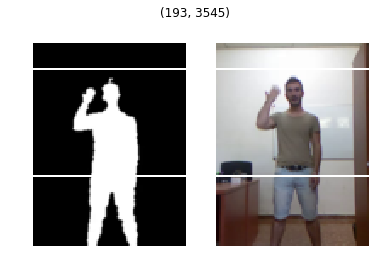

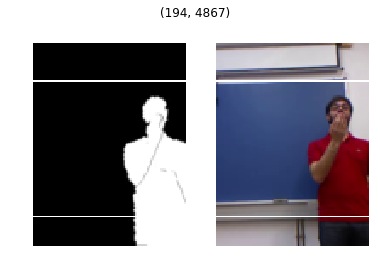

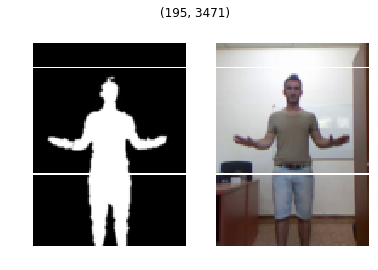

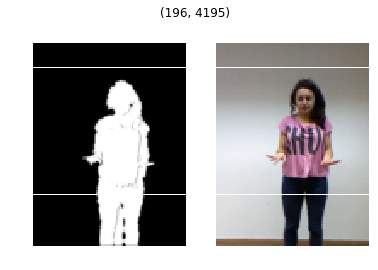

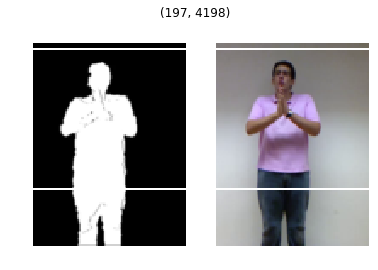

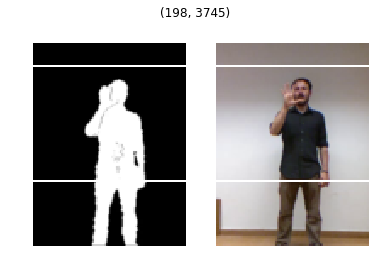

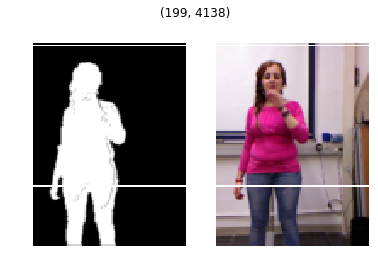

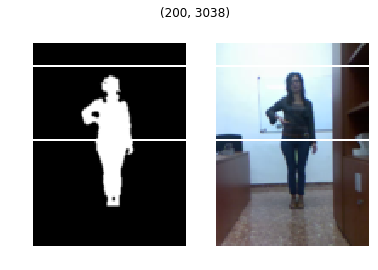

In [111]:
for s in subjects:
    samples = sub_info[s]
    
    nonzeros = int(sum([sub['nonzeros'] for sub in samples])/len(samples))
    bottom = int(sum([sub['bottom'] for sub in samples])/len(samples))
    top = int(sum([sub['top'] for sub in samples])/len(samples))
    height = bottom-top
    
    seg = data['segmentation'][samples[0]['id']].copy()
    rgb = data['rgb'][samples[0]['id']].copy()
    
    bottom = min(119, int(top+(nonzeros/6000)*height))
    height = bottom-top
    top = max(0, int(top-(height*0.1)))
        
    seg[top,...] = 255
    seg[bottom,...] = 255
    
    rgb[top,...] = 255
    rgb[bottom,...] = 255
        
    plot([seg, rgb], (s, nonzeros))

In [5]:
def process(i):
    sample = data['segmentation'][i][:, :, 0]

    # crop and scale segmentation to calculate body area
    
    # calculate top and bottom crop
    top = np.min(np.nonzero(np.any(sample, axis=1)))
    bottom = np.max(np.nonzero(np.any(sample, axis=1)))

    # calculate scaling factor
    factor = 120/int(bottom-top)

    # scale cropped image
    seg_tmp = data['segmentation'][i].copy()
    seg = cv2.resize(seg_tmp[top:bottom, :, :] ,(int(90*factor), 120), interpolation=cv2.INTER_CUBIC)

    # calculate body area (sum of pixel vals, this is why we scale)
    pix = seg.sum()

    # calculate std of masked depth
    mask = mask2(data['segmentation'][i])
    dep_masked = data['depth'][i]*mask
    std = np.std(dep_masked[dep_masked>0])

    # calculate prob of close-up photograph
    p_pix = sigmoid((pix-3250000)/90000)
    p_std = sigmoid(std-9.5)
    p = p_pix*p_pix*p_std

    # adjust bottom crop
    if not np.any(sample[118:120, :]):
        # person is completely in the image
        bottom = top+int((bottom-top)*0.5)
    elif(p < 0.125):
        # person is not close-up
        bottom = top+int((bottom-top)*0.65)

    # appromximate location of person in image
    mean = mean_column(sample[top:bottom, :])

    # calculate the scaling factor
    factor = 120/int(bottom-top)

    # calculate left and right crop
    left = 60+mean-int(60/factor)
    right = 60+mean+int(60/factor)

    # pad originals (in case person is way off-center and left<0 or right>=90)
    seg_tmp = data['segmentation'][i].copy()
    seg_tmp = np.lib.pad(seg_tmp, ((0, 0), (60, 60), (0, 0)), 'constant')

    rgb_tmp = data['rgb'][i].copy()
    rgb_tmp = np.lib.pad(rgb_tmp, ((0, 0), (60, 60), (0, 0)), 'constant')

    dep_tmp = data['depth'][i].copy()
    dep_tmp = np.lib.pad(dep_tmp, ((0, 0), (60, 60)), 'constant')

    # resize
    seg = cv2.resize(seg_tmp[top:bottom, left:right, :] ,(120, 120), interpolation=cv2.INTER_CUBIC)
    rgb = cv2.resize(rgb_tmp[top:bottom, left:right, :] ,(120, 120), interpolation=cv2.INTER_CUBIC)
    dep = cv2.resize(dep_tmp[top:bottom, left:right   ] ,(120, 120), interpolation=cv2.INTER_CUBIC)

    # mask rgb and depth
    rgb *= mask3(seg)
    dep *= mask2(seg)

    # normalize depth
    offset = int(dep[dep>0].mean() - 127)

    # if pixel value < offset, set it to 0 to avoid integer overflow
    if(dep[dep>0].min() < offset):
        dep[dep<offset] = 0

    dep[dep>0] = dep[dep>0]-offset

    # set background to 'inf'
    dep[dep==0] = 255

    return seg, rgb, dep

In [6]:
# process
processed = 0

for c, n in enumerate(chunks):
    
    size = n
    
    # make space for mirrored images
    if set_name == 'train':
        size *= 2
        
    # initialize empty chunk
    data_pp = {
        'n_samples': size,
        'seg':       empty(size),
        'rgb':       empty(size),
        'dep':       empty(size),
        'subject':   empty(size),
        'valid':     empty(size),
        'label':     empty(size),
        'weight':    empty(size),
    }
    
    for i in range(n):
        
        # copy labels and flags
        data_pp['subject'][i] = data['subjectLabels'][processed+i]
        data_pp['valid'  ][i] = data['valid'        ][processed+i]
        
        if set_name == 'train':
            data_pp['label'  ][i  ] = data['gestureLabels'][processed+i]
            data_pp['label'  ][n+i] = data['gestureLabels'][processed+i]
            data_pp['subject'][n+i] = data['subjectLabels'][processed+i]
            data_pp['valid'  ][n+i] = data['valid'        ][processed+i]
            data_pp['weight' ][i  ] = 5
            data_pp['weight' ][n+i] = 1
        
        # skip if invalid
        if(not data_pp['valid'][i]):
            continue

        # process sample
        seg, rgb, dep = process(processed+i)
        
        # write to chunk
        data_pp['seg'][i] = seg
        data_pp['rgb'][i] = rgb
        data_pp['dep'][i] = dep
        
        if set_name == 'train':
            # add mirrored images
            data_pp['seg'][n+i] = cv2.flip(seg, 1)
            data_pp['rgb'][n+i] = cv2.flip(rgb, 1)
            data_pp['dep'][n+i] = cv2.flip(dep, 1)
    
    processed += n
    
    # write to disk
    pickle.dump(data_pp, open('./data_pp/%s_%i.pkl' % (set_name, c), 'wb'))
    print('dumped chunk #%i to \'./data_pp/%s_%i.pkl\' (%i samples)' % (c, set_name, c, size))
    
    # clear chunk
    del data_pp
    
print('done')

dumped chunk #0 to './data_pp/test_0.pkl' (8190 samples)
done


In [7]:
# clear original data
del data